# Problema de negócio

**Análise de vendas de filiais de lojas de supermercado**

Analisando as vendas das lojas e sua dependência da área das lojas e da contagem diária de clientes

**Contexto**

Um supermercado é uma loja de autoatendimento que oferece uma grande variedade de alimentos, bebidas e produtos domésticos, organizados em seções. Esse tipo de loja é maior e tem uma seleção mais ampla do que as mercearias anteriores, mas é menor e mais limitada na variedade de mercadorias do que um hipermercado ou um grande mercado. No uso diário dos EUA, no entanto, "mercearia" é sinônimo de supermercado e não é usado para se referir a outros tipos de lojas que vendem mantimentos.

[https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount](https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount)

**Como o problema é resolvido atualmente ?**

    Os analistas de negócio usam a média das últimas vendas para estimar as próximas nas filiais em destaque.

    Baseline = Média das últimas vendas

    Deve-se calcular o erro que a atual solução traz e o seu custo financeiro

    Alavancas ( aumento de vendas, redução de stockout, redução de custos, aumento de faturamento, previsão de demanda)

# Entendimento dos dados

No conjunto de dados, você obterá dados de diferentes lojas de uma empresa de supermercado de acordo com seus IDs de loja que, para facilitar, foram convertidos em números inteiros positivos.

**ID da loja:** (Índice) ID da loja específica.

**Store_Area:** Área Física da loja em metro quadrado.

**Items_Available:** Número de diferentes itens disponíveis na loja correspondente.

**Daily_Customer_Count:** número de clientes que visitaram as lojas em média ao longo do mês.

**Store_Sales:** Vendas em (US$) que as lojas realizaram.

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import  Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import FeatureImportances


import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import mlflow.catboost

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import os
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

# Separação dos dados

 - Separar treino e teste
 - A amostra de teste será a base de cálculo do ROI 
 - Para calcular o ROI o baseline será a média de vendas por filial simulando a forma como os analistas de negócio estimam as vendas da rede de supermercadossklearn.neural_network

In [2]:
path = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\raw\Stores.csv'

data = pd.read_csv(path, sep=';')

In [3]:
data.head()

Store ID   Store_Area  Items_Available  Daily_Customer_Count  Store_Sales
0          1        1659             1961                   530        66490
1          2        1461             1752                   210        39820
2          3        1340             1609                   720        54010
3          4        1451             1748                   620        53730
4          5        1770             2111                   450        46620

In [4]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [5]:
train.shape

(716, 5)

In [6]:
test.shape

(180, 5)

In [7]:
# ETL interim
#train.to_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\train.csv',index=False)
#test.to_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\test.csv',index=False)

# EDA 
 - Na amostra de treino apenas
 - O teste não será visto pois é para simular o ambiente em produção

In [8]:
df_train = pd.read_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\train.csv', sep=',')

In [9]:
df_train.head()

Store ID   Store_Area  Items_Available  Daily_Customer_Count  Store_Sales
0        737        1098             1309                   860        59530
1        383        1454             1737                   870        23090
2        707        1495             1793                  1020        65300
3        818        1608             1962                   770        36280
4        119        1500             1798                   860        56710

In [10]:
# Sanit check

def sanit_check(df:pd.DataFrame):

    print(f'Número de linhas: {df.shape[0]} \n')
    print(f'Número de colunas {df.shape[1]} \n')
    print(f'Número de linhas duplicadas: {df.duplicated().sum()}\n')
    print(f'Número de linhas nulas:\n {df.isnull().sum()}')

    return None

In [11]:
sanit_check(df_train)

Número de linhas: 716 

Número de colunas 5 

Número de linhas duplicadas: 0

Número de linhas nulas:
 Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64


Não há dados duplicados ou nulos !

<Axes: >

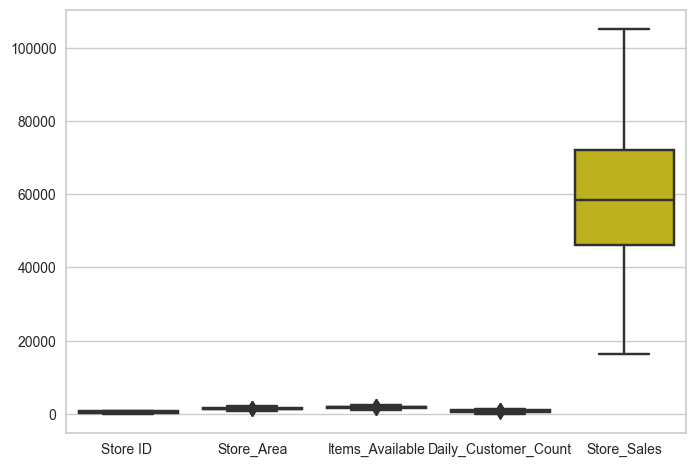

In [12]:
# Check outliers
sns.boxplot(df_train)

Aparentemente não temos outliers nos dados de treino

In [13]:
df_train.describe()

Store ID    Store_Area  Items_Available  Daily_Customer_Count  \
count  716.000000   716.000000       716.000000            716.000000   
mean   450.437151  1482.632682      1778.560056            785.237430   
std    257.862012   251.766360       301.446876            259.725136   
min      1.000000   775.000000       932.000000             70.000000   
25%    225.750000  1315.500000      1571.000000            610.000000   
50%    456.500000  1472.000000      1763.000000            770.000000   
75%    675.500000  1648.250000      1981.250000            950.000000   
max    896.000000  2229.000000      2667.000000           1560.000000   

         Store_Sales  
count     716.000000  
mean    59170.377095  
std     17357.070464  
min     16370.000000  
25%     46190.000000  
50%     58385.000000  
75%     72127.500000  
max    105150.000000

Achados da descritiva acima:

    - Store_Area, Items_Available,	Daily_Customer_Count têm um leve desvio padrão considerando a distância entre os valores máximos e minimos destas variáveis
    - Store_Sales tem um desvio padrão maior, acredito que esta target não tenha uma distribuição normal deve-se testar esta hipótese mais tarde
    - A venda máxima diária foi de $ 105.150,00 e a minima de $ 16.370,00

# Hipóteses de negócio

### 1 - Quanto maior a área física da loja maior as vendas !

<Axes: xlabel='Store_Area', ylabel='Store_Sales'>

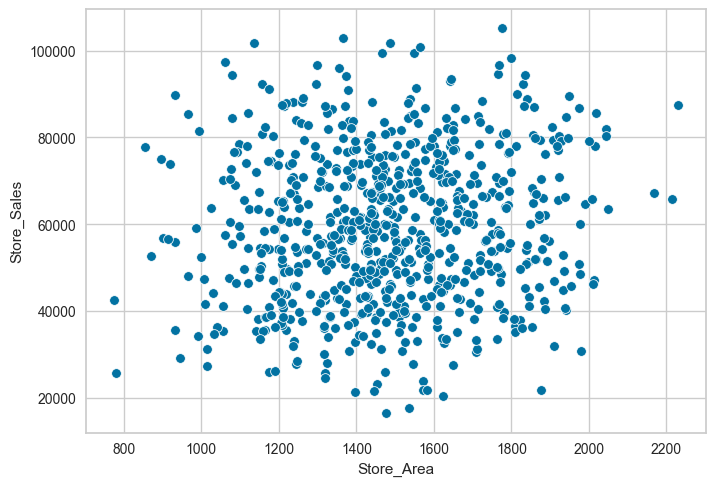

In [14]:
sns.scatterplot(x=df_train['Store_Area'], y=df_train['Store_Sales'])

- Analisando o gráfico aparenta ser falsa esta hipótese, não vejo uma relação linear forte entre os dados

- As maiores vendas se concetram em lojas com 1200 a 1800 metros quadrados

In [15]:
# Testar a H0 de que há uma correlação linear entre a área física da loja e as vendas. 
from scipy.stats import pearsonr

In [16]:
corr, p_value = pearsonr(df_train['Store_Area'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.09928637110096922
Valor p: 0.007845391240498711


O valor p correspondente testa a hipótese nula de que não há correlação linear entre as duas variáveis. Se o valor p for menor que um nível de significância pré-definido (por exemplo, 0,05), isso indica que a hipótese nula pode ser rejeitada em favor da hipótese alternativa de que há uma correlação linear significativa entre as duas variáveis. O valor da correlação indica a direção e a magnitude da relação, ou seja, quanto maior a área física da loja, maior as vendas, mantidas as outras variáveis constantes.

H0 aceita ! Lembrando que correlação não é causalidade

### 2 - Quanto mais itens disponíveis na loja maior as vendas !

<Axes: xlabel='Items_Available', ylabel='Store_Sales'>

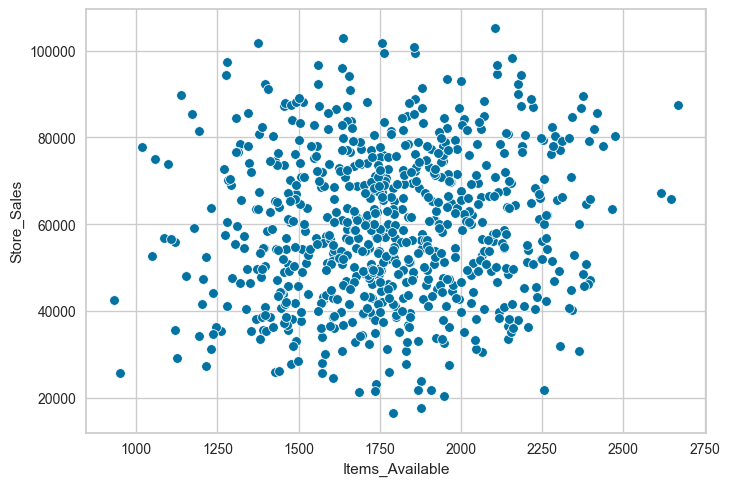

In [17]:
sns.scatterplot(x=df_train['Items_Available'], y=df_train['Store_Sales'])

- Os dados estão bastante dispersos também não há uma forte correlação entre a quantidade de itens para avaliação e o valor de vendas
- Os maiores valores de vendas se concetram na quantidade de itens para avaliação entre 1250 e 2250.

In [18]:
corr, p_value = pearsonr(df_train['Items_Available'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.10009049620048739
Valor p: 0.007355773008398902


H0 aceita ! Hipótese verdadeira.

### 3 - Quanto mais visitas na loja maior as vendas !

<Axes: xlabel='Daily_Customer_Count', ylabel='Store_Sales'>

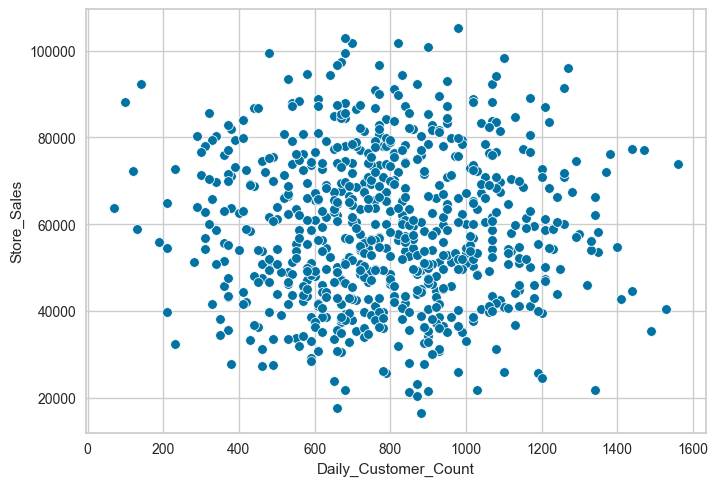

In [19]:
sns.scatterplot(x=df_train['Daily_Customer_Count'], y=df_train['Store_Sales'])

- Pelo gráfico tambem não temos uma forte correlação entre as variáveis
- Os maiores valores de vendas se concetram entre 600 e 1000 visitantes nas lojas

In [20]:
corr, p_value = pearsonr(df_train['Daily_Customer_Count'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: -0.01391553868890451
Valor p: 0.7100999525203255


H0 rejeitada ! Há uma correlação negativa entre as variáveis, quanto maior o número de visitantes menor é o valor de vendas.

    - Deve-se investigar o porquê e a causa, pois há um viés em pensarmos que quanto mais visitantes maiores as chances de compra, porém não é isto que oconteceu.
    - Será que quanto maior o número de visitantes pior é o atendimento ? Ou os clientes não gostam de esperar demais nas filas ? Deve-se investigar no campo !

# Análise Multivariada

In [21]:
# Verificar a correlação entre todas as variáveis 
corr = df_train.corr()

corr.style.background_gradient(cmap= 'coolwarm')

# Análise bivariada

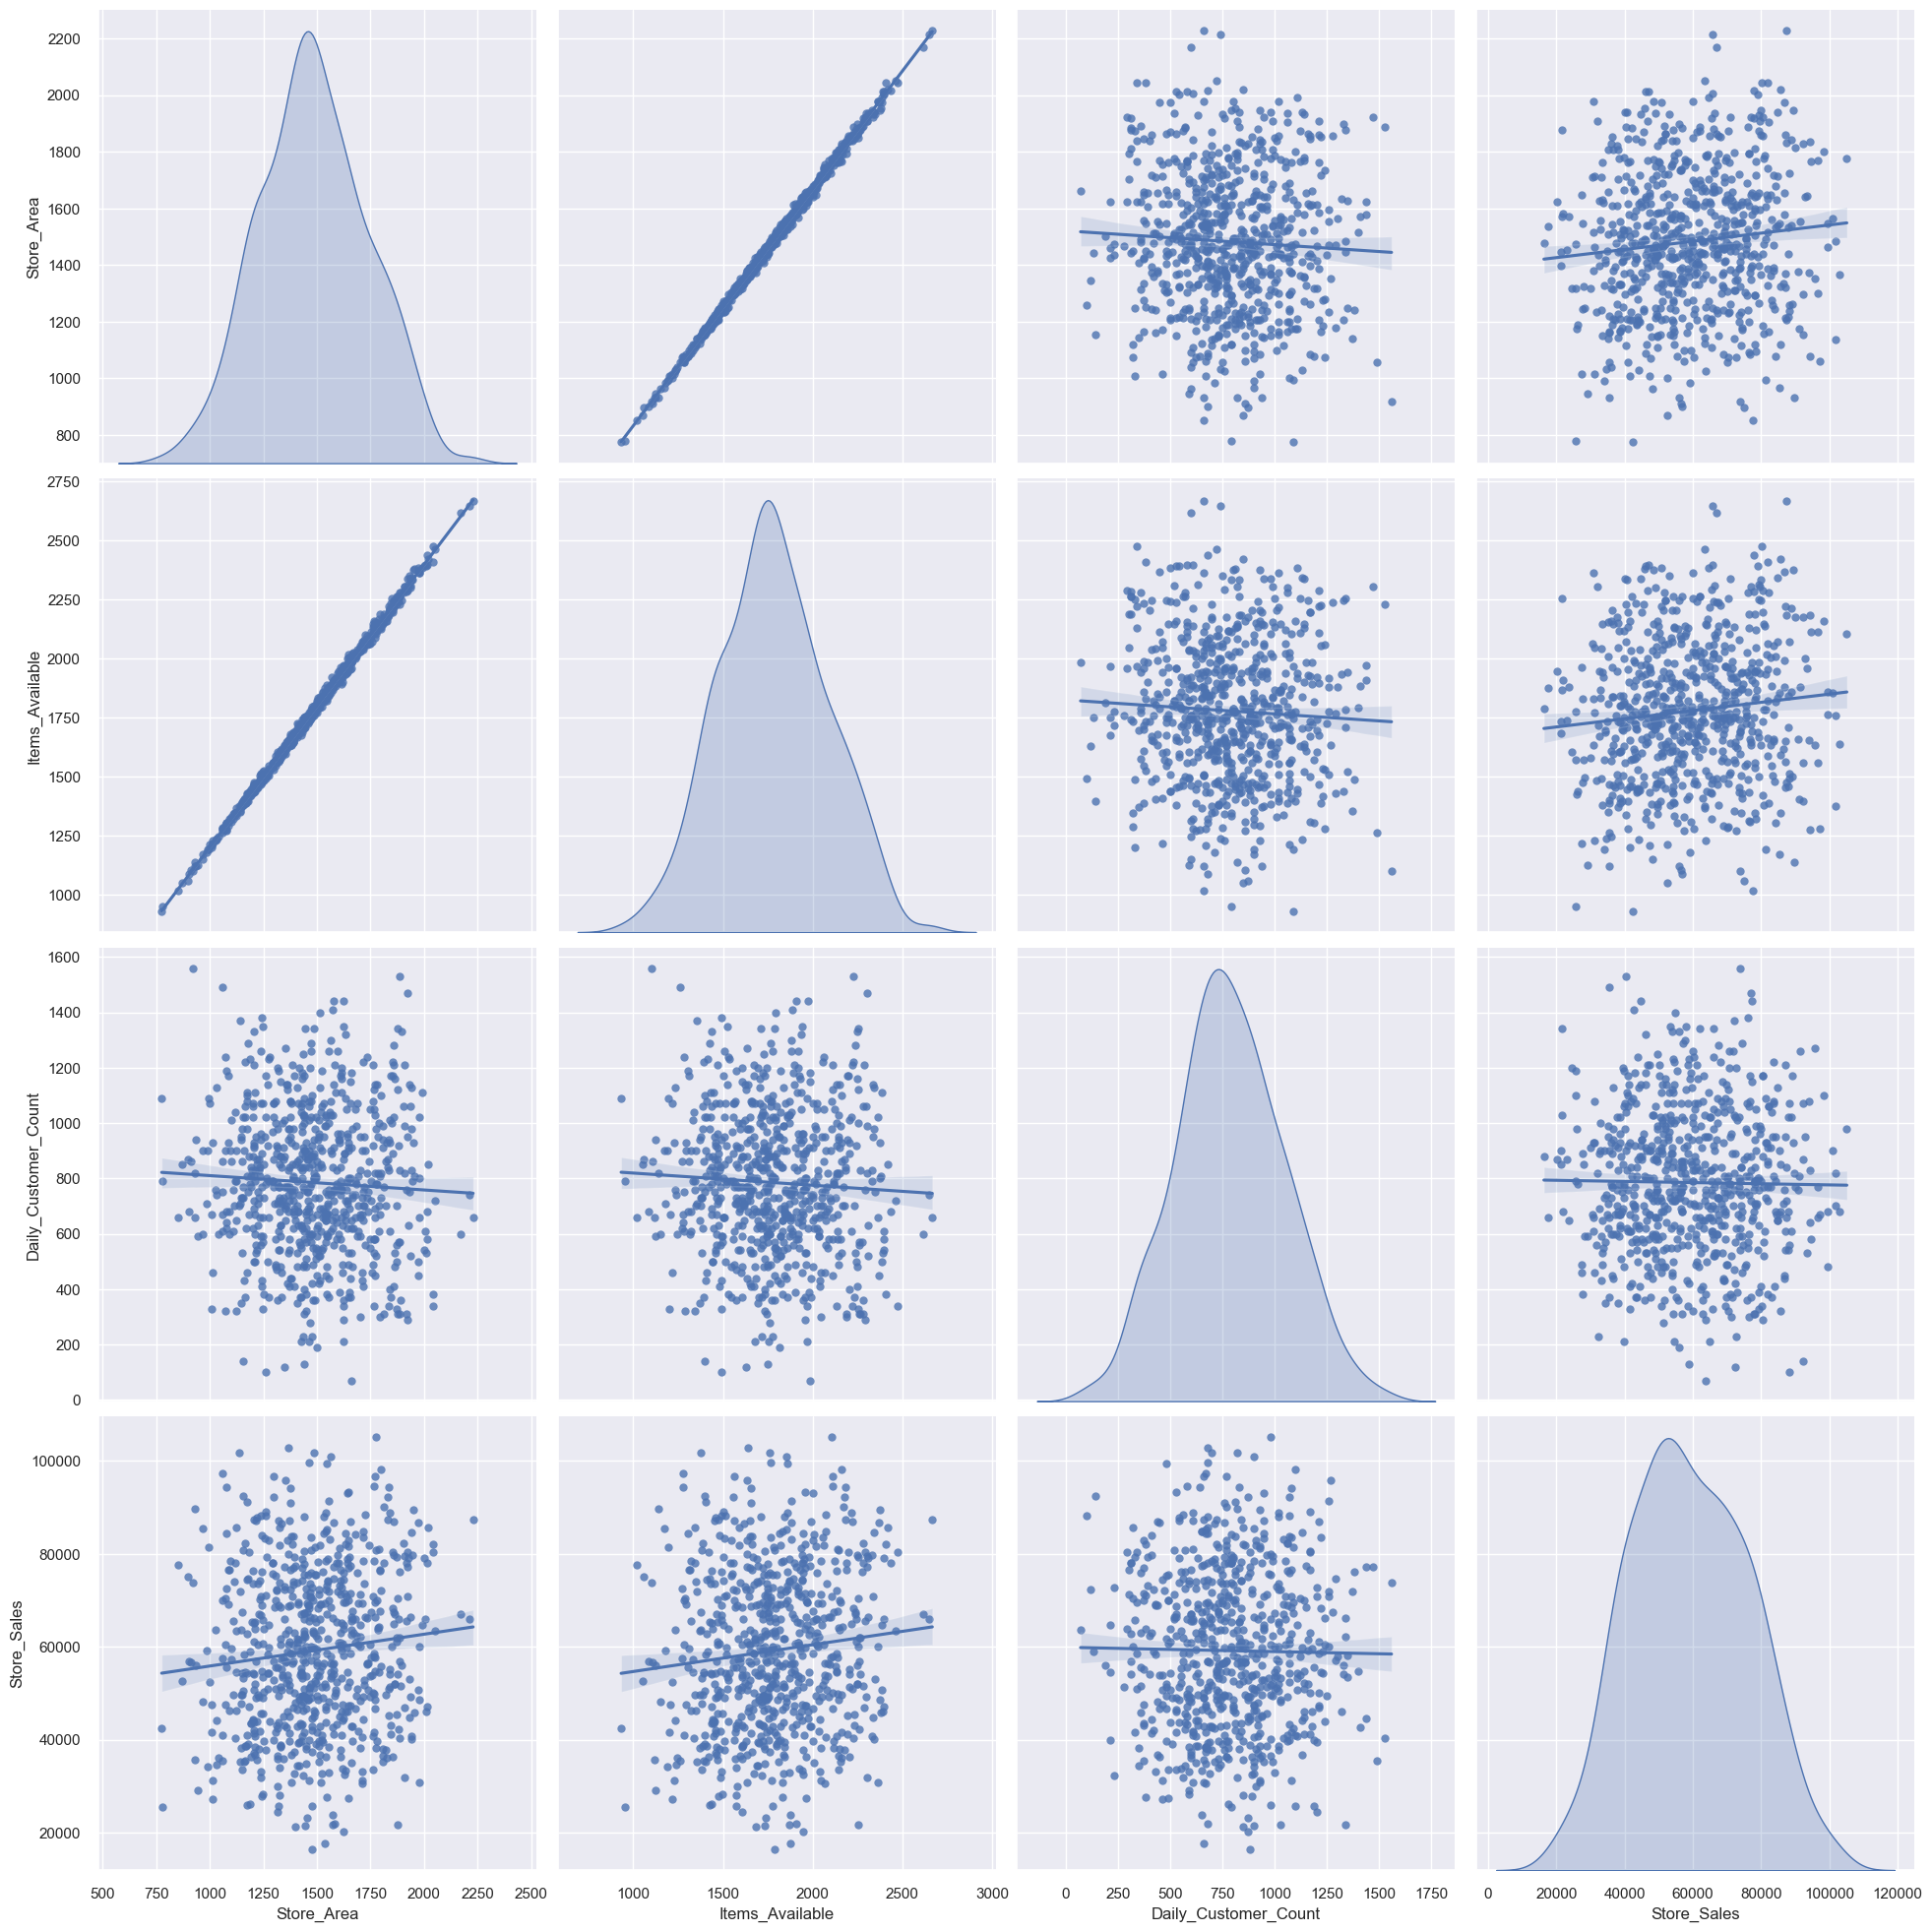

In [22]:
sns.set()
sns.pairplot(df_train.iloc[:,[1,2,3,4]],height = 5 ,kind ='reg',diag_kind='kde')
plt.show()

- A uma forte correlação entre Store_Area e Items_Available
- A correlações positivas fracas entre as variáveis Store_Area e Items_Available com a target Store_Sales

Dito isto será um desafio montar um modelo linear que consiga bons resultados com estas variáveis.

# Análise Univariada

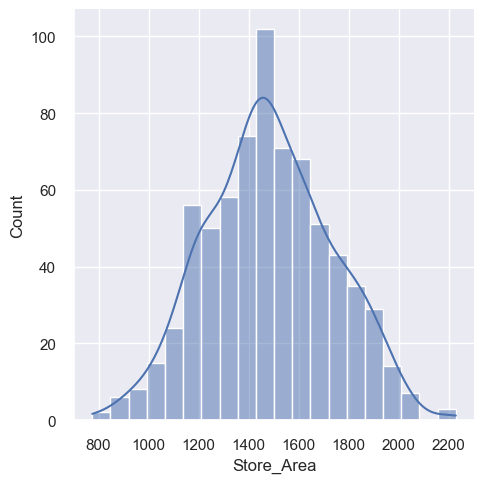

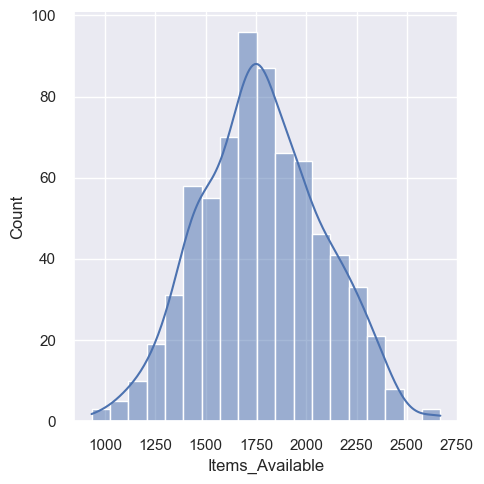

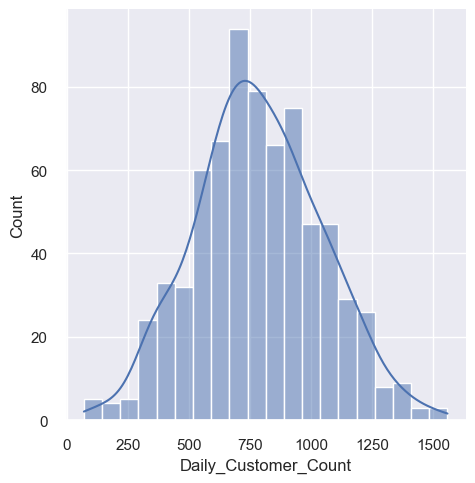

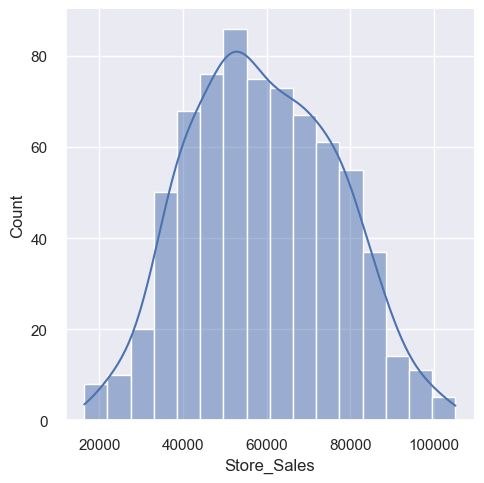

In [23]:
for col in df_train.iloc[:,[1,2,3,4]].columns.to_list():

    sns.displot(df_train[col], kde=True)

- Os gráficos apresentam as variáveis com as distribuições de dados em formato de sino, mas não tenho certeza se elas têm uma distribuição normal, para validar a premissa dos modelos lineares.
- Vou fazer alguns testes de hipóteses nestas variáveis para ter certeza !

In [24]:
from scipy import stats

In [25]:
def test_norm(data: pd.DataFrame):
    for col in data.columns:
        stat, p = stats.shapiro(data[col])
        print(f'Coluna {col}: Estatística de teste = {stat:.3f}, p-valor = {p:.3f}')

        if p > 0.05:
            print(f'Os dados da coluna {col} têm distribuição normal.')
        else:
            print(f'Os dados da coluna {col} não têm distribuição normal.')

In [26]:
test_norm(df_train.iloc[:,[1,2,3,4]])

Coluna Store_Area: Estatística de teste = 0.997, p-valor = 0.139
Os dados da coluna Store_Area têm distribuição normal.
Coluna Items_Available: Estatística de teste = 0.997, p-valor = 0.157
Os dados da coluna Items_Available têm distribuição normal.
Coluna Daily_Customer_Count: Estatística de teste = 0.998, p-valor = 0.390
Os dados da coluna Daily_Customer_Count têm distribuição normal.
Coluna Store_Sales: Estatística de teste = 0.992, p-valor = 0.001
Os dados da coluna Store_Sales não têm distribuição normal.


Por não termos uma distribuiçõ normal na target talvez precisaremos alterar sua natureza para facilitar a previsão dos algoritmos ou usar modelos robustos para estes tipos de dados 

# Baseline de média dos analistas nos dados de teste

In [27]:
# teste
df_teste = pd.read_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\test.csv', sep=',')

In [28]:
# Modelo  de média

# Calcular média de vendas 
mean_sales = np.mean(df_teste['Store_Sales'])

In [29]:
# Prever a média de vendas para cada loja
predictions = np.full(len(df_teste), mean_sales)

In [30]:
# Calcular erro baseline MAE RMSE MAPE

R2 = r2_score(df_teste['Store_Sales'], predictions) 
RMSE = np.sqrt(mean_squared_error(df_teste['Store_Sales'], predictions))
MAPE = mean_absolute_percentage_error(df_teste['Store_Sales'], predictions)

In [31]:
print(f"R2: {R2:.2f}")
print(f"RMSE: {RMSE:.2f}")
print(f"MAPE: {MAPE:.2%}")

R2: 0.00
RMSE: 16493.87
MAPE: 25.74%


    - O modelo de média tem um erro em torno de 25,74% 
    - Nosso objetivo será reduzir este erro

# Feature Engineering

- 

# Modelagem - Machine Learning

## Treino/Validação

In [32]:
# Separar variáveis independentes e dependente
X = df_train.drop(['Store_Sales'], axis=1)
y = df_train['Store_Sales']

In [33]:
X.head()

Store ID   Store_Area  Items_Available  Daily_Customer_Count
0        737        1098             1309                   860
1        383        1454             1737                   870
2        707        1495             1793                  1020
3        818        1608             1962                   770
4        119        1500             1798                   860

In [34]:
y

0      59530
1      23090
2      65300
3      36280
4      56710
       ...  
711    69310
712    26220
713    48950
714    52060
715    89080
Name: Store_Sales, Length: 716, dtype: int64

In [35]:
# definir função para treinar e validar os modelos e registrar os resultados dos experimentos

def train_validation_eval(model_name, model, X, y, gridsearch=False, params_grid=None, run_name=None, experiment_name=None, path_save_fig=None):
    
    
    logging.info("Função train_validation_eval iniciada")
    
    # listas de métricas para append futuro
    r2 = []
    rmse = []
    mape = []
    
    # inicializar variável best_model, best_param e default_params
    best_model = None
    best_param = None
    default_params = None
    
    logging.info("Iniciando loop de validação cruzada")
    # Cross validation
    n_splits = 5
    KFOLD = KFold(n_splits=n_splits,shuffle=True, random_state=42)
    fold = 0 
    
    # Split treino e validação hold out
    for train_ix, val_ix in KFOLD.split(X):
        
        fold+=1
        
        X_train, X_valid = X.iloc[train_ix, :], X.iloc[val_ix, :]
        y_train, y_valid = y.iloc[train_ix], y.iloc[val_ix]
        
        if gridsearch == False:
            logging.info(f"Treinando {model_name} com parâmetros padrão, fold {fold}")
            # Treino modelo default
            model.fit(X_train, y_train)
            logging.info(f"Prevendo conjunto de validação com {model_name} padrão, fold {fold}")
            # pegar parâtros default
            default_params = model.get_params()
            # Prever na validaçã
            yhat = model.predict(X_valid)
            
        else:
            logging.info(f"Treinando {model_name} com parâmetros otimizados pelo GridSearch, fold {fold}")
            # Definir espaço de gridsearch
            search = GridSearchCV(model, params_grid, scoring='neg_root_mean_squared_error', cv=KFOLD, n_jobs=-1)
            # Ajustar modelo
            search_result = search.fit(X_train, y_train) 
            # melhor parâmetro
            best_param = search_result.best_params_
            # melhor modelo
            best_model = search_result.best_estimator_
            logging.info(f"Prevendo conjunto de validação com {model_name} otimizado, fold {fold}")
            # Prever na validação com melhor modelo
            yhat = best_model.predict(X_valid)
        
        logging.info("Avaliando resultados nos dados de validação")
        #Avaliação numerica
        # R2
        R2 = r2_score(y_valid, yhat)
        r2.append(R2)
        # RMSE
        RMSE = np.sqrt(mean_squared_error(y_valid, yhat))
        rmse.append(RMSE)
        # MAPE
        MAPE = mean_absolute_percentage_error(y_valid, yhat)
        mape.append(MAPE)
        
    # Erro de previsão com a reta da regressão
    p = np.polyfit(y_valid, yhat, 1)
    plt.scatter(y_valid, yhat, alpha=0.5)
    plt.plot(y_valid, np.polyval(p, y_valid), color='red')
    plt.xlabel('Valor Real')
    plt.ylabel('Previsão')
    plt.title(f'Reta da Regressão para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
    
    # Resíduos dos erros
    residuals = y_valid - yhat
    plt.hist(residuals, bins=25)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Erros Resíduais para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()

    # Avaliação na validação
    print(f"Modelo:  {model_name}")
    print(f"R2 CV:   {np.mean(r2):.2f}")
    print(f"RMSE CV: {np.mean(rmse):.2f}")
    print(f"MAPE CV: {np.mean(mape)*100:.2f}%")
    
    if gridsearch == True:
        # Imprimir melhor parâmetro e modelo após o loop de validação cruzada
        print(f"Melhores parâmetros: {best_param}")
        print(f"Melhor modelo: {best_model}")
    
    logging.info("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    
    with mlflow.start_run(run_name=run_name):
        
        if best_param is not None:  
            mlflow.log_params(best_param)
            
        if default_params is not None:
            mlflow.log_params(default_params)
            
        mlflow.log_metrics({'R2 CV': np.mean(r2),
                            'RMSE CV': np.mean(rmse),
                            'MAPE CV': np.mean(mape)
                           })
        
        try:
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
            mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"))
        except:
            pass
        
        for framework in [mlflow.sklearn, mlflow.xgboost, mlflow.lightgbm, mlflow.catboost]:
            try:
                framework.log_model(model, model_name)
                break
            except Exception:
                pass
        
    mlflow.end_run()
        
    return logging.info('Ciclo de vida dos modelos rastreado com sucesso!')


### Algoritmos com parâmetros padrão

In [36]:
path_save_fig = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\reports\figures'

2023-04-19 09:57:41,184 - Função train_validation_eval iniciada
2023-04-19 09:57:41,186 - Iniciando loop de validação cruzada
2023-04-19 09:57:41,189 - Treinando LinearRegression com parâmetros padrão, fold 1
2023-04-19 09:57:41,199 - Prevendo conjunto de validação com LinearRegression padrão, fold 1
2023-04-19 09:57:41,202 - Avaliando resultados nos dados de validação
2023-04-19 09:57:41,206 - Treinando LinearRegression com parâmetros padrão, fold 2
2023-04-19 09:57:41,209 - Prevendo conjunto de validação com LinearRegression padrão, fold 2
2023-04-19 09:57:41,211 - Avaliando resultados nos dados de validação
2023-04-19 09:57:41,214 - Treinando LinearRegression com parâmetros padrão, fold 3
2023-04-19 09:57:41,219 - Prevendo conjunto de validação com LinearRegression padrão, fold 3
2023-04-19 09:57:41,221 - Avaliando resultados nos dados de validação
2023-04-19 09:57:41,225 - Treinando LinearRegression com parâmetros padrão, fold 4
2023-04-19 09:57:41,231 - Prevendo conjunto de valida

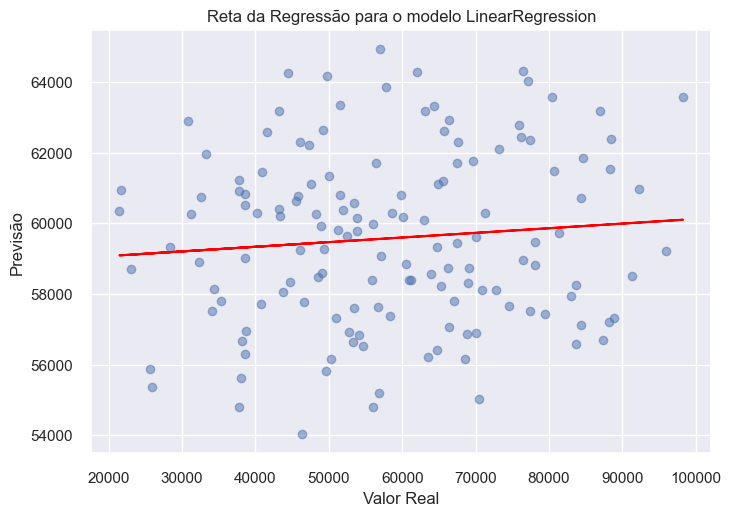

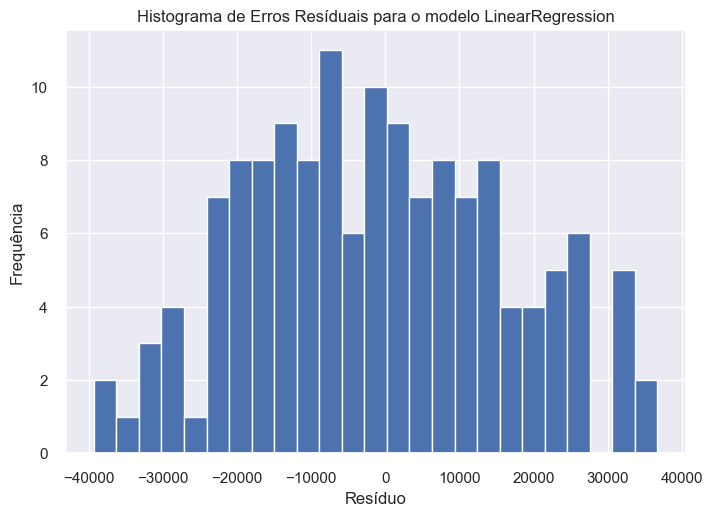

2023-04-19 09:57:42,051 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/19 09:57:42 INFO mlflow.tracking.fluent: Experiment with name 'Modelos com parâmetros padrão - treino e validação' does not exist. Creating a new experiment.


Modelo:  LinearRegression
R2 CV:   -0.00
RMSE CV: 17284.97
MAPE CV: 28.55%


2023-04-19 09:57:49,320 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:57:49,320 - Função train_validation_eval iniciada
2023-04-19 09:57:49,321 - Iniciando loop de validação cruzada
2023-04-19 09:57:49,324 - Treinando RandomForestRegressor com parâmetros padrão, fold 1
2023-04-19 09:57:49,580 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 1
2023-04-19 09:57:49,600 - Avaliando resultados nos dados de validação
2023-04-19 09:57:49,603 - Treinando RandomForestRegressor com parâmetros padrão, fold 2
2023-04-19 09:57:49,885 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 2
2023-04-19 09:57:49,897 - Avaliando resultados nos dados de validação
2023-04-19 09:57:49,900 - Treinando RandomForestRegressor com parâmetros padrão, fold 3
2023-04-19 09:57:50,166 - Prevendo conjunto de validação com RandomForestRegressor padrão, fold 3
2023-04-19 09:57:50,175 - Avaliando resultados nos dados de validação
2023-04-19 09:57:50,179 - Trein

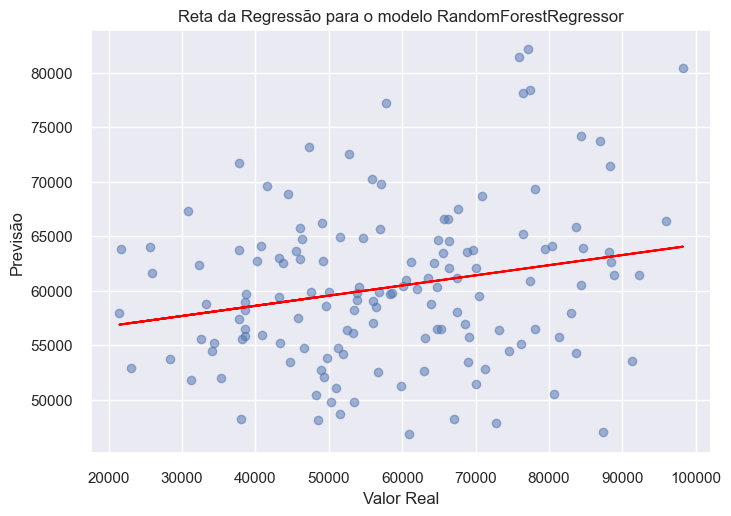

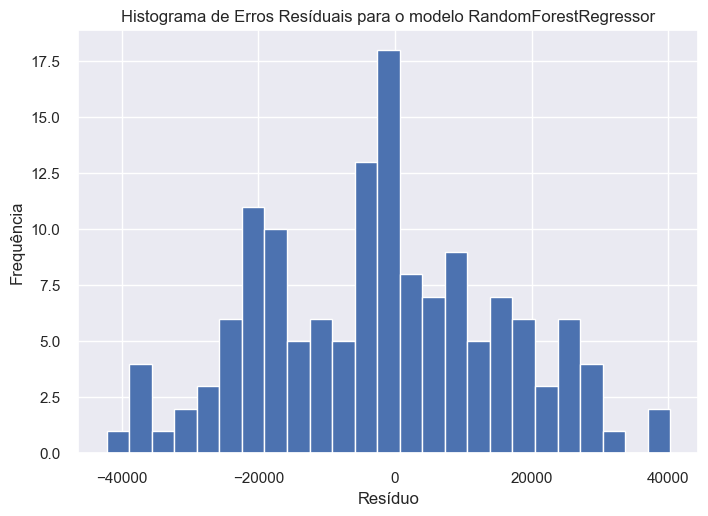

2023-04-19 09:57:51,519 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor
R2 CV:   -0.06
RMSE CV: 17782.32
MAPE CV: 29.01%


2023-04-19 09:57:54,844 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:57:54,844 - Função train_validation_eval iniciada
2023-04-19 09:57:54,845 - Iniciando loop de validação cruzada
2023-04-19 09:57:54,849 - Treinando Ridge com parâmetros padrão, fold 1
2023-04-19 09:57:54,857 - Prevendo conjunto de validação com Ridge padrão, fold 1
2023-04-19 09:57:54,860 - Avaliando resultados nos dados de validação
2023-04-19 09:57:54,863 - Treinando Ridge com parâmetros padrão, fold 2
2023-04-19 09:57:54,867 - Prevendo conjunto de validação com Ridge padrão, fold 2
2023-04-19 09:57:54,869 - Avaliando resultados nos dados de validação
2023-04-19 09:57:54,873 - Treinando Ridge com parâmetros padrão, fold 3
2023-04-19 09:57:54,875 - Prevendo conjunto de validação com Ridge padrão, fold 3
2023-04-19 09:57:54,878 - Avaliando resultados nos dados de validação
2023-04-19 09:57:54,881 - Treinando Ridge com parâmetros padrão, fold 4
2023-04-19 09:57:54,885 - Prevendo conjunto de validaçã

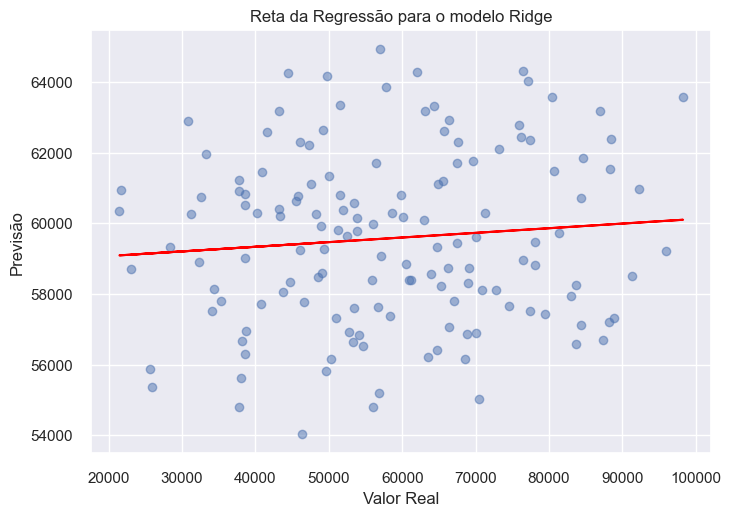

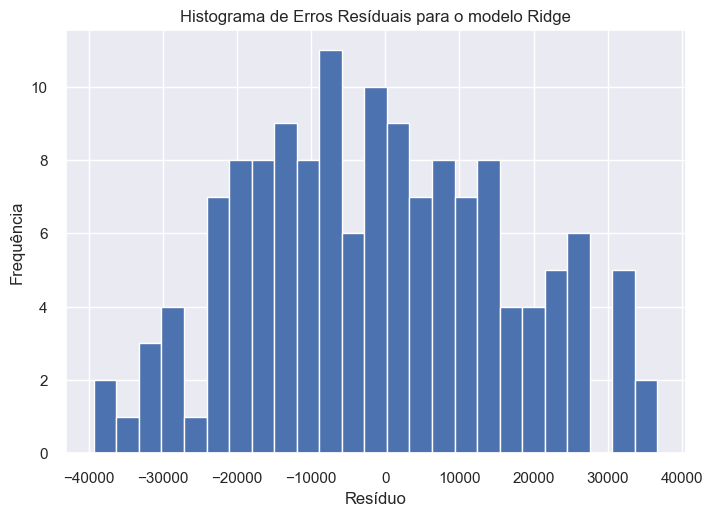

2023-04-19 09:57:55,687 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Ridge
R2 CV:   -0.00
RMSE CV: 17284.97
MAPE CV: 28.55%


2023-04-19 09:57:59,601 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:57:59,602 - Função train_validation_eval iniciada
2023-04-19 09:57:59,603 - Iniciando loop de validação cruzada
2023-04-19 09:57:59,606 - Treinando Lasso com parâmetros padrão, fold 1
2023-04-19 09:57:59,610 - Prevendo conjunto de validação com Lasso padrão, fold 1
2023-04-19 09:57:59,612 - Avaliando resultados nos dados de validação
2023-04-19 09:57:59,617 - Treinando Lasso com parâmetros padrão, fold 2
2023-04-19 09:57:59,622 - Prevendo conjunto de validação com Lasso padrão, fold 2
2023-04-19 09:57:59,624 - Avaliando resultados nos dados de validação
2023-04-19 09:57:59,628 - Treinando Lasso com parâmetros padrão, fold 3
2023-04-19 09:57:59,633 - Prevendo conjunto de validação com Lasso padrão, fold 3
2023-04-19 09:57:59,637 - Avaliando resultados nos dados de validação
2023-04-19 09:57:59,640 - Treinando Lasso com parâmetros padrão, fold 4
2023-04-19 09:57:59,646 - Prevendo conjunto de validaçã

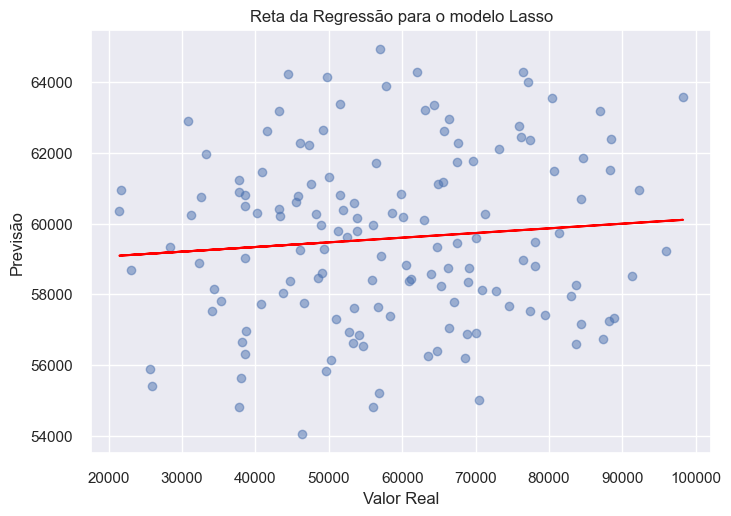

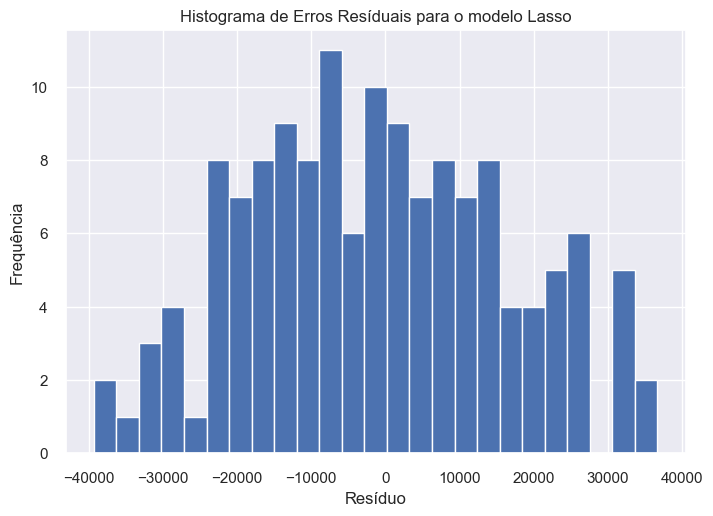

2023-04-19 09:58:00,532 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso
R2 CV:   0.00
RMSE CV: 17280.09
MAPE CV: 28.54%


2023-04-19 09:58:04,491 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:58:04,493 - Função train_validation_eval iniciada
2023-04-19 09:58:04,495 - Iniciando loop de validação cruzada
2023-04-19 09:58:04,498 - Treinando ElasticNet com parâmetros padrão, fold 1
2023-04-19 09:58:04,503 - Prevendo conjunto de validação com ElasticNet padrão, fold 1
2023-04-19 09:58:04,507 - Avaliando resultados nos dados de validação
2023-04-19 09:58:04,511 - Treinando ElasticNet com parâmetros padrão, fold 2
2023-04-19 09:58:04,517 - Prevendo conjunto de validação com ElasticNet padrão, fold 2
2023-04-19 09:58:04,519 - Avaliando resultados nos dados de validação
2023-04-19 09:58:04,524 - Treinando ElasticNet com parâmetros padrão, fold 3
2023-04-19 09:58:04,529 - Prevendo conjunto de validação com ElasticNet padrão, fold 3
2023-04-19 09:58:04,531 - Avaliando resultados nos dados de validação
2023-04-19 09:58:04,536 - Treinando ElasticNet com parâmetros padrão, fold 4
2023-04-19 09:58:04,

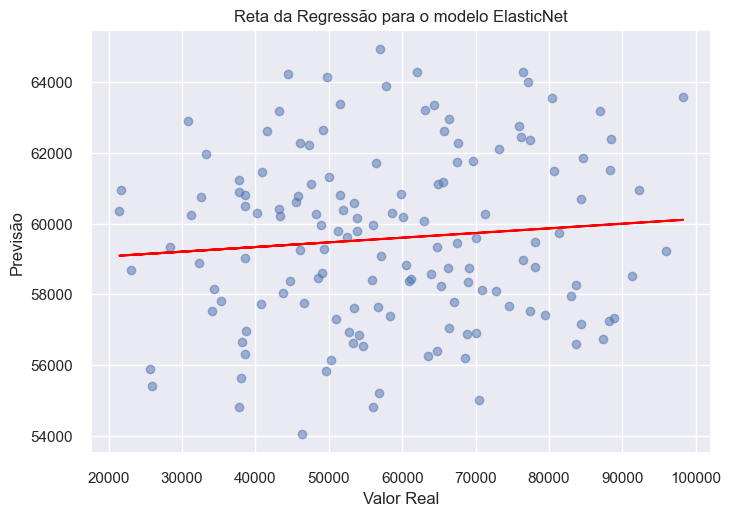

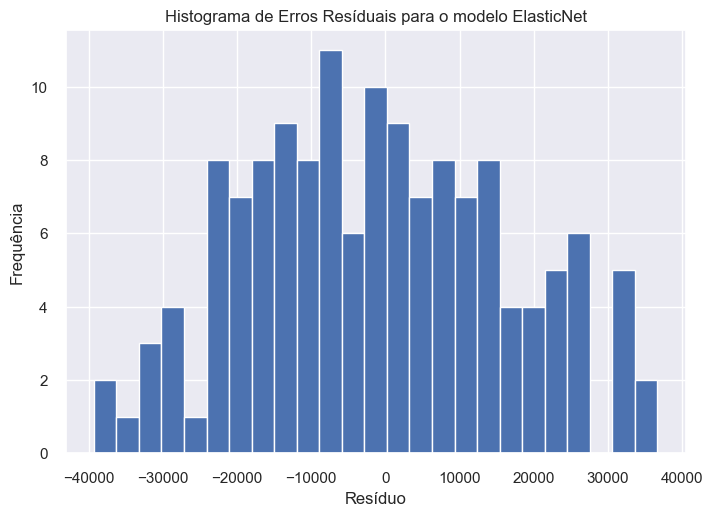

2023-04-19 09:58:05,560 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  ElasticNet
R2 CV:   0.00
RMSE CV: 17279.95
MAPE CV: 28.54%


2023-04-19 09:58:09,567 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:58:09,568 - Função train_validation_eval iniciada
2023-04-19 09:58:09,569 - Iniciando loop de validação cruzada
2023-04-19 09:58:09,573 - Treinando SVR com parâmetros padrão, fold 1
2023-04-19 09:58:09,585 - Prevendo conjunto de validação com SVR padrão, fold 1
2023-04-19 09:58:09,593 - Avaliando resultados nos dados de validação
2023-04-19 09:58:09,596 - Treinando SVR com parâmetros padrão, fold 2
2023-04-19 09:58:09,608 - Prevendo conjunto de validação com SVR padrão, fold 2
2023-04-19 09:58:09,617 - Avaliando resultados nos dados de validação
2023-04-19 09:58:09,621 - Treinando SVR com parâmetros padrão, fold 3
2023-04-19 09:58:09,634 - Prevendo conjunto de validação com SVR padrão, fold 3
2023-04-19 09:58:09,643 - Avaliando resultados nos dados de validação
2023-04-19 09:58:09,647 - Treinando SVR com parâmetros padrão, fold 4
2023-04-19 09:58:09,664 - Prevendo conjunto de validação com SVR padr

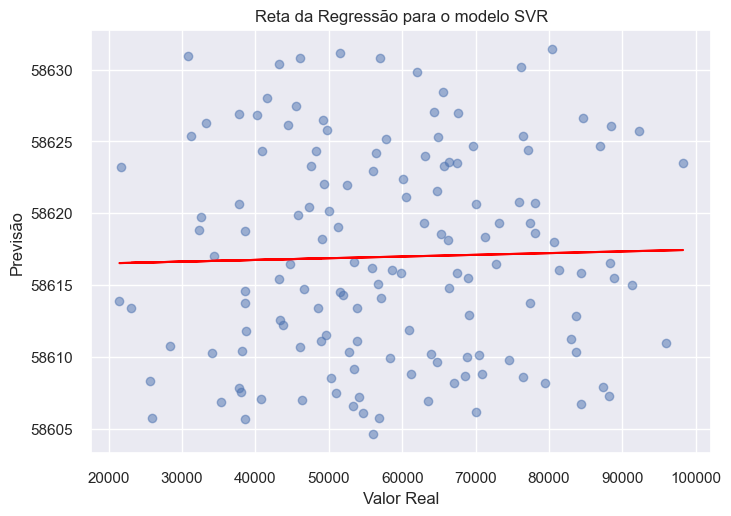

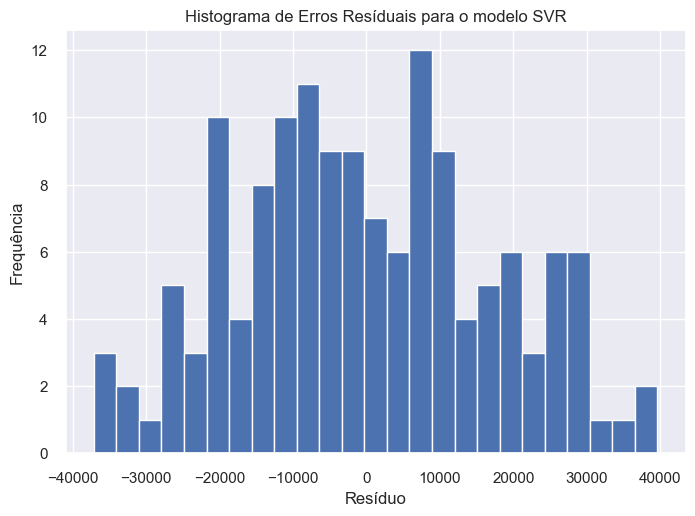

2023-04-19 09:58:10,514 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  SVR
R2 CV:   -0.01
RMSE CV: 17373.16
MAPE CV: 28.26%


2023-04-19 09:58:14,158 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:58:14,158 - Função train_validation_eval iniciada
2023-04-19 09:58:14,159 - Iniciando loop de validação cruzada
2023-04-19 09:58:14,162 - Treinando MLPRegressor com parâmetros padrão, fold 1
2023-04-19 09:58:14,745 - Prevendo conjunto de validação com MLPRegressor padrão, fold 1
2023-04-19 09:58:14,748 - Avaliando resultados nos dados de validação
2023-04-19 09:58:14,751 - Treinando MLPRegressor com parâmetros padrão, fold 2
2023-04-19 09:58:15,311 - Prevendo conjunto de validação com MLPRegressor padrão, fold 2
2023-04-19 09:58:15,315 - Avaliando resultados nos dados de validação
2023-04-19 09:58:15,319 - Treinando MLPRegressor com parâmetros padrão, fold 3
2023-04-19 09:58:15,899 - Prevendo conjunto de validação com MLPRegressor padrão, fold 3
2023-04-19 09:58:15,902 - Avaliando resultados nos dados de validação
2023-04-19 09:58:15,905 - Treinando MLPRegressor com parâmetros padrão, fold 4
2023-0

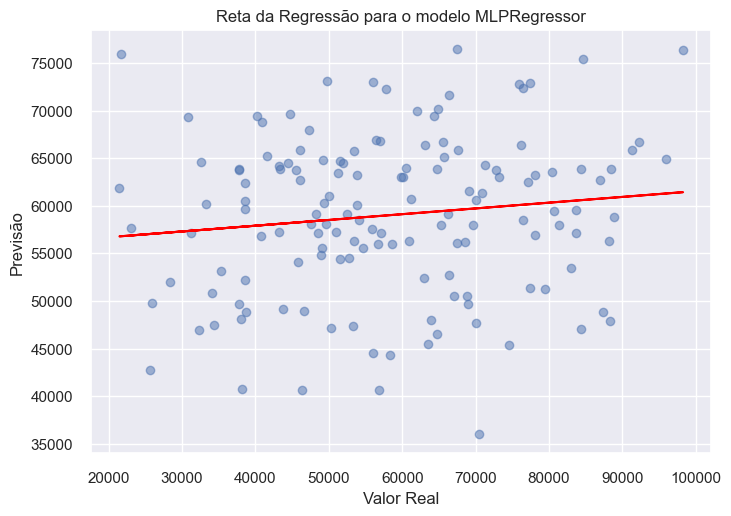

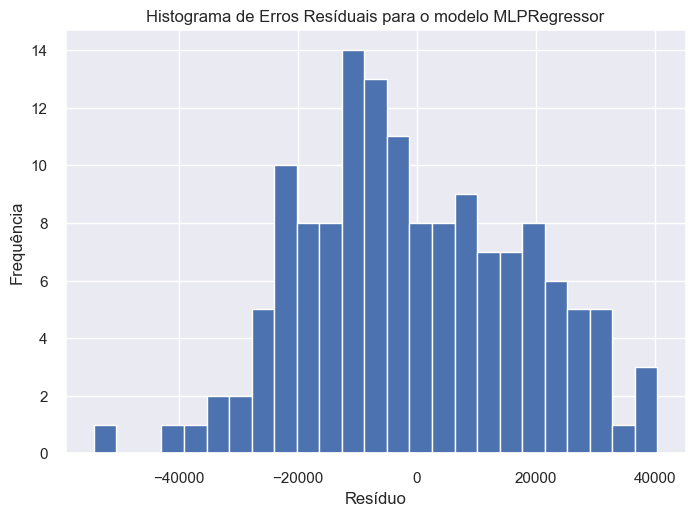

2023-04-19 09:58:17,974 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  MLPRegressor
R2 CV:   -0.13
RMSE CV: 18366.03
MAPE CV: 28.80%


2023-04-19 09:58:21,957 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:58:21,957 - Função train_validation_eval iniciada
2023-04-19 09:58:21,958 - Iniciando loop de validação cruzada
2023-04-19 09:58:21,961 - Treinando XGBRegressor com parâmetros padrão, fold 1
2023-04-19 09:58:22,096 - Prevendo conjunto de validação com XGBRegressor padrão, fold 1
2023-04-19 09:58:22,108 - Avaliando resultados nos dados de validação
2023-04-19 09:58:22,114 - Treinando XGBRegressor com parâmetros padrão, fold 2
2023-04-19 09:58:22,242 - Prevendo conjunto de validação com XGBRegressor padrão, fold 2
2023-04-19 09:58:22,248 - Avaliando resultados nos dados de validação
2023-04-19 09:58:22,252 - Treinando XGBRegressor com parâmetros padrão, fold 3
2023-04-19 09:58:22,374 - Prevendo conjunto de validação com XGBRegressor padrão, fold 3
2023-04-19 09:58:22,379 - Avaliando resultados nos dados de validação
2023-04-19 09:58:22,383 - Treinando XGBRegressor com parâmetros padrão, fold 4
2023-0

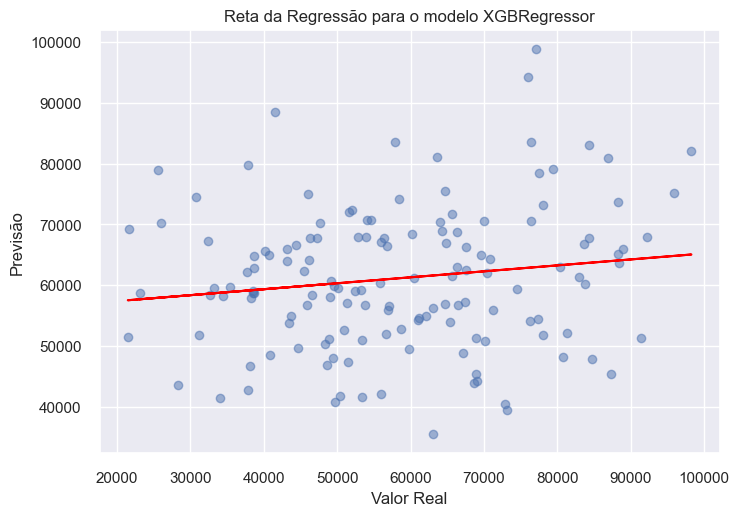

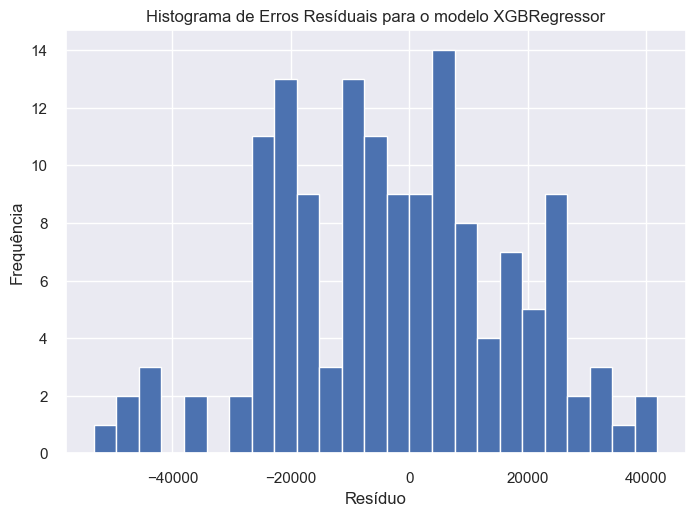

2023-04-19 09:58:23,685 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  XGBRegressor
R2 CV:   -0.30
RMSE CV: 19635.31
MAPE CV: 31.83%


2023-04-19 09:58:27,558 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:58:27,559 - Função train_validation_eval iniciada
2023-04-19 09:58:27,560 - Iniciando loop de validação cruzada
2023-04-19 09:58:27,564 - Treinando LGBMRegressor com parâmetros padrão, fold 1
2023-04-19 09:58:27,679 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 1
2023-04-19 09:58:27,689 - Avaliando resultados nos dados de validação
2023-04-19 09:58:27,697 - Treinando LGBMRegressor com parâmetros padrão, fold 2
2023-04-19 09:58:27,790 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 2
2023-04-19 09:58:27,802 - Avaliando resultados nos dados de validação
2023-04-19 09:58:27,808 - Treinando LGBMRegressor com parâmetros padrão, fold 3
2023-04-19 09:58:27,914 - Prevendo conjunto de validação com LGBMRegressor padrão, fold 3
2023-04-19 09:58:27,917 - Avaliando resultados nos dados de validação
2023-04-19 09:58:27,921 - Treinando LGBMRegressor com parâmetros padrão, fold 4

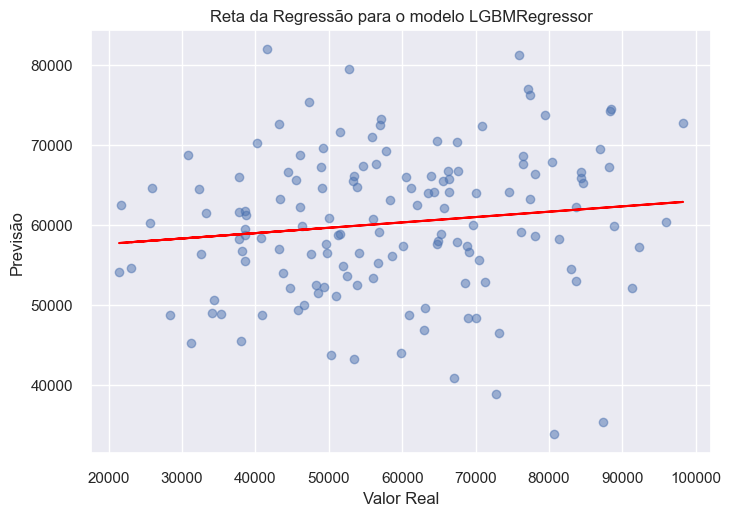

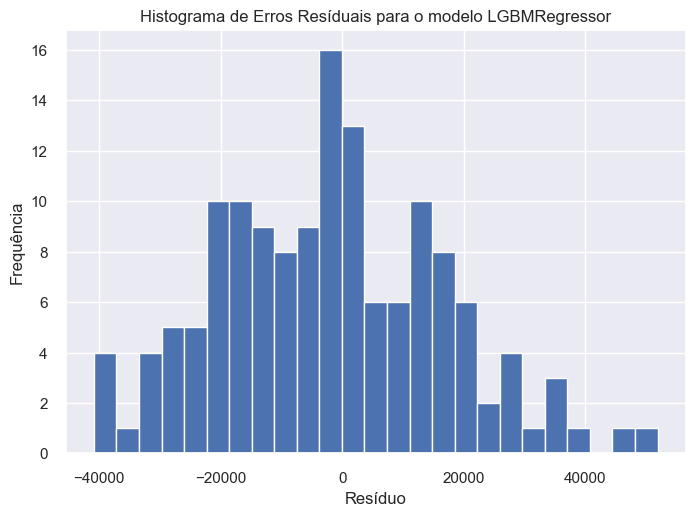

2023-04-19 09:58:29,124 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  LGBMRegressor
R2 CV:   -0.19
RMSE CV: 18839.49
MAPE CV: 30.66%


2023-04-19 09:58:33,395 - Ciclo de vida dos modelos rastreado com sucesso!
2023-04-19 09:58:33,396 - Função train_validation_eval iniciada
2023-04-19 09:58:33,397 - Iniciando loop de validação cruzada
2023-04-19 09:58:33,401 - Treinando CatBoostRegressor com parâmetros padrão, fold 1


Learning rate set to 0.037484
0:	learn: 17606.6235938	total: 149ms	remaining: 2m 29s
1:	learn: 17575.3313267	total: 151ms	remaining: 1m 15s
2:	learn: 17545.9476793	total: 152ms	remaining: 50.6s
3:	learn: 17518.5690416	total: 153ms	remaining: 38.2s
4:	learn: 17497.9672724	total: 155ms	remaining: 30.8s
5:	learn: 17472.3817266	total: 156ms	remaining: 25.8s
6:	learn: 17453.3220799	total: 157ms	remaining: 22.3s
7:	learn: 17431.3308801	total: 158ms	remaining: 19.6s
8:	learn: 17410.5849868	total: 159ms	remaining: 17.5s
9:	learn: 17393.4168213	total: 160ms	remaining: 15.8s
10:	learn: 17364.0951438	total: 161ms	remaining: 14.5s
11:	learn: 17331.2118400	total: 162ms	remaining: 13.4s
12:	learn: 17302.3218196	total: 163ms	remaining: 12.4s
13:	learn: 17279.3839094	total: 164ms	remaining: 11.6s
14:	learn: 17255.7188943	total: 165ms	remaining: 10.9s
15:	learn: 17243.6554023	total: 166ms	remaining: 10.2s
16:	learn: 17239.3542220	total: 167ms	remaining: 9.68s
17:	learn: 17213.2792332	total: 169ms	remai

2023-04-19 09:58:34,947 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 1
2023-04-19 09:58:34,953 - Avaliando resultados nos dados de validação
2023-04-19 09:58:34,956 - Treinando CatBoostRegressor com parâmetros padrão, fold 2


964:	learn: 8612.5203772	total: 1.25s	remaining: 45.5ms
965:	learn: 8611.1358213	total: 1.25s	remaining: 44.2ms
966:	learn: 8608.4540941	total: 1.25s	remaining: 42.9ms
967:	learn: 8605.2210415	total: 1.26s	remaining: 41.6ms
968:	learn: 8603.0764198	total: 1.26s	remaining: 40.3ms
969:	learn: 8599.0814026	total: 1.26s	remaining: 38.9ms
970:	learn: 8593.7832970	total: 1.26s	remaining: 37.6ms
971:	learn: 8592.1050960	total: 1.26s	remaining: 36.3ms
972:	learn: 8588.4038107	total: 1.26s	remaining: 35ms
973:	learn: 8581.1298562	total: 1.26s	remaining: 33.8ms
974:	learn: 8578.2290785	total: 1.26s	remaining: 32.4ms
975:	learn: 8570.9320528	total: 1.27s	remaining: 31.1ms
976:	learn: 8565.1175791	total: 1.27s	remaining: 29.8ms
977:	learn: 8562.3640427	total: 1.27s	remaining: 28.5ms
978:	learn: 8560.7740459	total: 1.27s	remaining: 27.2ms
979:	learn: 8555.3216151	total: 1.27s	remaining: 25.9ms
980:	learn: 8551.8929595	total: 1.27s	remaining: 24.6ms
981:	learn: 8547.4591792	total: 1.27s	remaining: 2

2023-04-19 09:58:36,445 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 2
2023-04-19 09:58:36,449 - Avaliando resultados nos dados de validação
2023-04-19 09:58:36,453 - Treinando CatBoostRegressor com parâmetros padrão, fold 3


923:	learn: 9027.0314276	total: 1.16s	remaining: 95.7ms
924:	learn: 9026.0668179	total: 1.16s	remaining: 94.4ms
925:	learn: 9023.7248851	total: 1.17s	remaining: 93.1ms
926:	learn: 9017.1851316	total: 1.17s	remaining: 91.9ms
927:	learn: 9006.7822919	total: 1.17s	remaining: 90.6ms
928:	learn: 8998.5733760	total: 1.17s	remaining: 89.3ms
929:	learn: 8992.1400792	total: 1.17s	remaining: 88.1ms
930:	learn: 8991.4198865	total: 1.17s	remaining: 86.8ms
931:	learn: 8986.2630588	total: 1.17s	remaining: 85.6ms
932:	learn: 8979.0759158	total: 1.17s	remaining: 84.3ms
933:	learn: 8968.5209622	total: 1.17s	remaining: 83ms
934:	learn: 8961.5328310	total: 1.18s	remaining: 81.8ms
935:	learn: 8958.2526696	total: 1.18s	remaining: 80.5ms
936:	learn: 8946.5069391	total: 1.18s	remaining: 79.2ms
937:	learn: 8936.9861280	total: 1.18s	remaining: 78ms
938:	learn: 8926.8294180	total: 1.18s	remaining: 76.7ms
939:	learn: 8922.9792357	total: 1.18s	remaining: 75.4ms
940:	learn: 8920.2166957	total: 1.18s	remaining: 74.

2023-04-19 09:58:37,920 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 3
2023-04-19 09:58:37,923 - Avaliando resultados nos dados de validação
2023-04-19 09:58:37,927 - Treinando CatBoostRegressor com parâmetros padrão, fold 4


902:	learn: 8782.0642811	total: 1.1s	remaining: 119ms
903:	learn: 8777.3968872	total: 1.11s	remaining: 118ms
904:	learn: 8773.8104371	total: 1.11s	remaining: 116ms
905:	learn: 8767.2700304	total: 1.11s	remaining: 115ms
906:	learn: 8763.4475124	total: 1.11s	remaining: 114ms
907:	learn: 8761.2102335	total: 1.11s	remaining: 113ms
908:	learn: 8759.3445050	total: 1.11s	remaining: 112ms
909:	learn: 8758.7366828	total: 1.11s	remaining: 110ms
910:	learn: 8751.2587573	total: 1.12s	remaining: 109ms
911:	learn: 8748.8671801	total: 1.12s	remaining: 108ms
912:	learn: 8748.3348858	total: 1.12s	remaining: 107ms
913:	learn: 8740.4349124	total: 1.12s	remaining: 106ms
914:	learn: 8736.3268159	total: 1.12s	remaining: 104ms
915:	learn: 8733.3968273	total: 1.12s	remaining: 103ms
916:	learn: 8728.5772691	total: 1.13s	remaining: 102ms
917:	learn: 8725.9829029	total: 1.13s	remaining: 101ms
918:	learn: 8724.3195877	total: 1.13s	remaining: 99.4ms
919:	learn: 8721.9253363	total: 1.13s	remaining: 98.2ms
920:	lear

2023-04-19 09:58:39,285 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 4
2023-04-19 09:58:39,290 - Avaliando resultados nos dados de validação
2023-04-19 09:58:39,292 - Treinando CatBoostRegressor com parâmetros padrão, fold 5


934:	learn: 8776.3480691	total: 1.07s	remaining: 74.7ms
935:	learn: 8773.0325272	total: 1.08s	remaining: 73.6ms
936:	learn: 8768.8953497	total: 1.08s	remaining: 72.5ms
937:	learn: 8763.8044302	total: 1.08s	remaining: 71.3ms
938:	learn: 8751.4321072	total: 1.08s	remaining: 70.2ms
939:	learn: 8749.9943180	total: 1.08s	remaining: 69ms
940:	learn: 8741.2054323	total: 1.08s	remaining: 67.9ms
941:	learn: 8738.2390475	total: 1.08s	remaining: 66.7ms
942:	learn: 8730.6813201	total: 1.08s	remaining: 65.6ms
943:	learn: 8725.1124580	total: 1.09s	remaining: 64.5ms
944:	learn: 8720.6557879	total: 1.09s	remaining: 63.3ms
945:	learn: 8710.3358682	total: 1.09s	remaining: 62.2ms
946:	learn: 8703.5368036	total: 1.09s	remaining: 61ms
947:	learn: 8701.8712160	total: 1.09s	remaining: 59.9ms
948:	learn: 8692.7559968	total: 1.09s	remaining: 58.7ms
949:	learn: 8683.1930044	total: 1.09s	remaining: 57.6ms
950:	learn: 8680.5124000	total: 1.09s	remaining: 56.4ms
951:	learn: 8677.1649302	total: 1.1s	remaining: 55.3

2023-04-19 09:58:40,778 - Prevendo conjunto de validação com CatBoostRegressor padrão, fold 5
2023-04-19 09:58:40,784 - Avaliando resultados nos dados de validação


931:	learn: 8725.1403849	total: 1.13s	remaining: 82.8ms
932:	learn: 8720.5609202	total: 1.14s	remaining: 81.6ms
933:	learn: 8709.2725718	total: 1.14s	remaining: 80.4ms
934:	learn: 8704.3200370	total: 1.14s	remaining: 79.3ms
935:	learn: 8692.6487864	total: 1.14s	remaining: 78.1ms
936:	learn: 8690.9053157	total: 1.14s	remaining: 77ms
937:	learn: 8688.5662882	total: 1.15s	remaining: 75.8ms
938:	learn: 8682.9076790	total: 1.15s	remaining: 74.7ms
939:	learn: 8680.4820414	total: 1.15s	remaining: 73.5ms
940:	learn: 8676.8868205	total: 1.15s	remaining: 72.3ms
941:	learn: 8672.9597646	total: 1.15s	remaining: 71.1ms
942:	learn: 8666.3397127	total: 1.16s	remaining: 69.9ms
943:	learn: 8664.0887129	total: 1.16s	remaining: 68.7ms
944:	learn: 8658.0736896	total: 1.16s	remaining: 67.4ms
945:	learn: 8649.4556042	total: 1.16s	remaining: 66.2ms
946:	learn: 8645.3229626	total: 1.16s	remaining: 65ms
947:	learn: 8640.4245780	total: 1.16s	remaining: 63.8ms
948:	learn: 8638.6544570	total: 1.17s	remaining: 62.

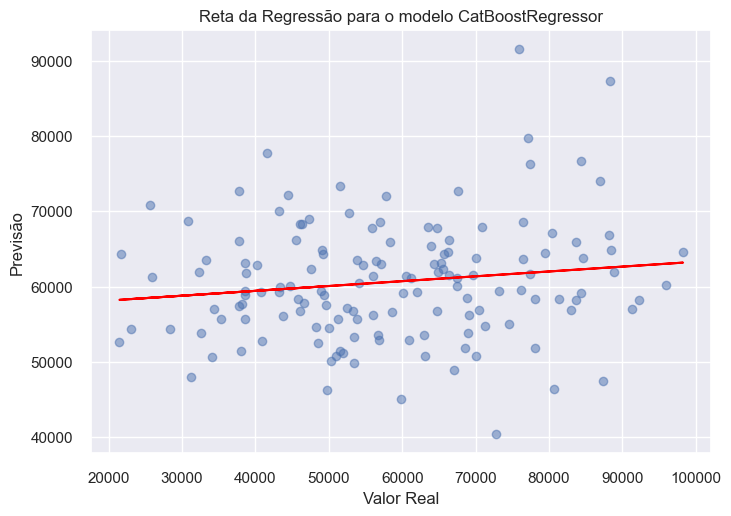

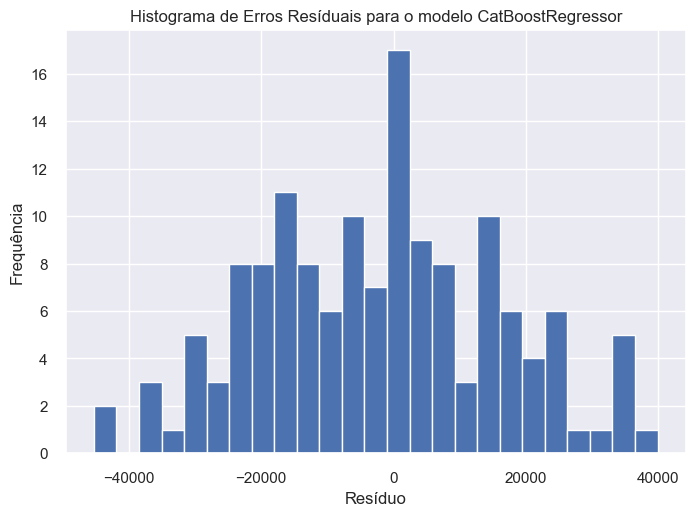

2023-04-19 09:58:41,658 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  CatBoostRegressor
R2 CV:   -0.10
RMSE CV: 18135.30
MAPE CV: 29.57%


2023-04-19 09:58:45,562 - Ciclo de vida dos modelos rastreado com sucesso!


In [37]:
# definir lista de algoritmos a serem testados
algoritmos = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('ElasticNet', ElasticNet()),
    ('SVR', SVR()),
    ('MLPRegressor', MLPRegressor()),
    ('XGBRegressor', XGBRegressor()),
    ('LGBMRegressor', LGBMRegressor()),
    ('CatBoostRegressor', CatBoostRegressor())
]

experiment_name = 'Modelos com parâmetros padrão - treino e validação'

# Treinar e validar os vários algoritmos acima:
for model_name, model in algoritmos:
    
    # Executar função sem GridSearch
    date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    model_name_date = model_name + ' - ' + date
    
    train_validation_eval(model_name=model_name, model=model, X=X, y=y, gridsearch=False, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

#### Resultados 

-  Avaliando os resultados no MLflow o modelo ElasticNet obteve o melhor resultado de RMSE dentre os algoritmos testados.
- Irei otimizar alguns modelos para finalizar o banchmark completo

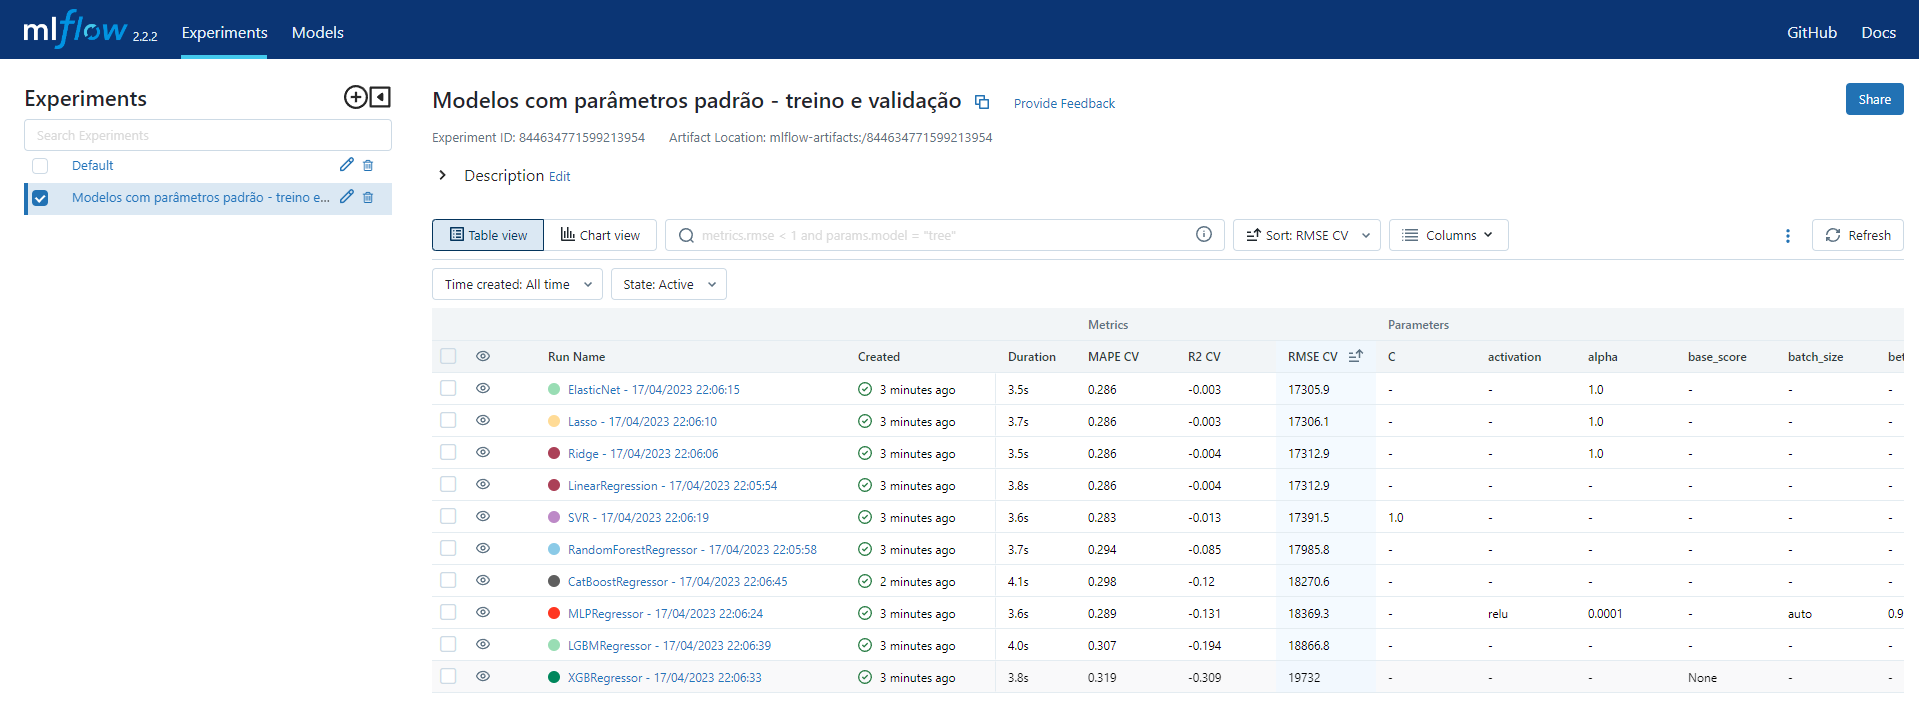

### GridSearch nos modelos que tendem a ter melhores resultados otimizados

#### ElasticNet

2023-04-18 15:45:07,864 - Função train_validation_eval iniciada
2023-04-18 15:45:07,866 - Iniciando loop de validação cruzada
2023-04-18 15:45:07,870 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 1
2023-04-18 15:45:09,478 - Prevendo conjunto de validação com ElasticNet otimizado, fold 1
2023-04-18 15:45:09,480 - Avaliando resultados nos dados de validação
2023-04-18 15:45:09,483 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 2
2023-04-18 15:45:10,978 - Prevendo conjunto de validação com ElasticNet otimizado, fold 2
2023-04-18 15:45:10,980 - Avaliando resultados nos dados de validação
2023-04-18 15:45:10,983 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 3
2023-04-18 15:45:12,693 - Prevendo conjunto de validação com ElasticNet otimizado, fold 3
2023-04-18 15:45:12,693 - Avaliando resultados nos dados de validação
2023-04-18 15:45:12,693 - Treinando ElasticNet com parâmetros otimizados pelo GridSearch, fold 4
2023-0

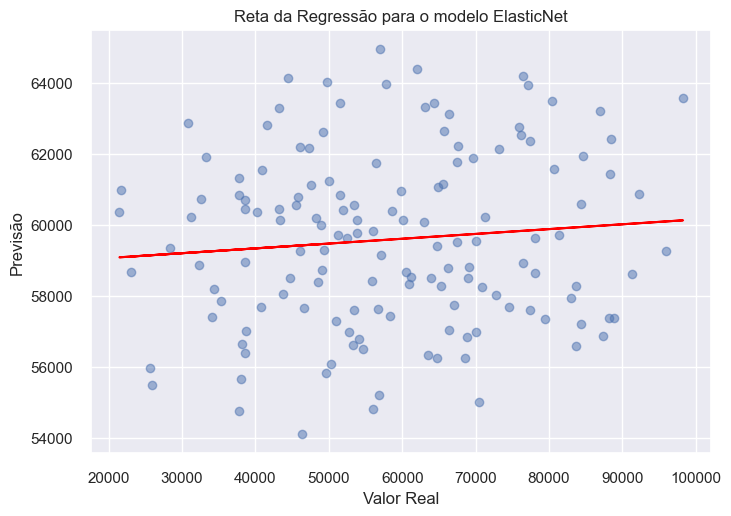

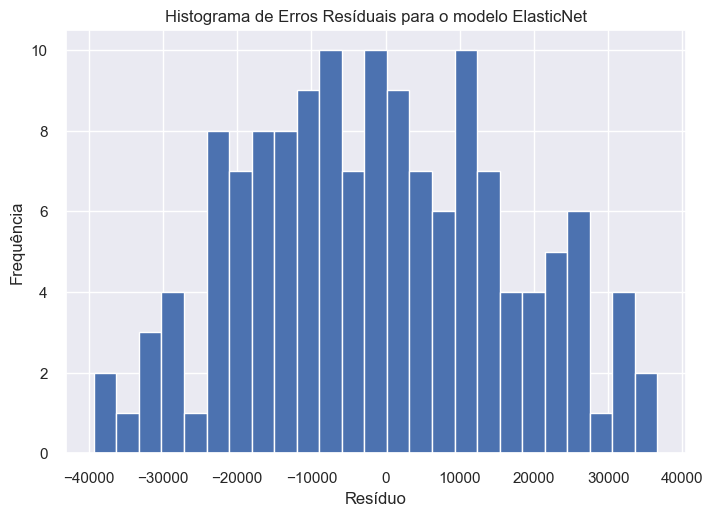

2023-04-18 15:45:16,640 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  ElasticNet
R2 CV:   0.00
RMSE CV: 17270.21
MAPE CV: 28.52%
Melhores parâmetros: {'alpha': 2.0, 'fit_intercept': True, 'l1_ratio': 0.1, 'max_iter': 100, 'tol': 0.001}
Melhor modelo: ElasticNet(alpha=2.0, l1_ratio=0.1, max_iter=100, tol=0.001)


2023-04-18 15:45:20,429 - Ciclo de vida dos modelos rastreado com sucesso!


In [69]:
# definir algoritmo a ser otimizado
Elastic = ElasticNet()

# define os hiperparâmetros a serem testados
params = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [100, 500, 1000],
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'ElasticNet'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=Elastic, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-19 09:58:45,586 - Função train_validation_eval iniciada
2023-04-19 09:58:45,588 - Iniciando loop de validação cruzada
2023-04-19 09:58:45,591 - Treinando Elastic_opt com parâmetros padrão, fold 1
2023-04-19 09:58:45,595 - Prevendo conjunto de validação com Elastic_opt padrão, fold 1
2023-04-19 09:58:45,597 - Avaliando resultados nos dados de validação
2023-04-19 09:58:45,600 - Treinando Elastic_opt com parâmetros padrão, fold 2
2023-04-19 09:58:45,604 - Prevendo conjunto de validação com Elastic_opt padrão, fold 2
2023-04-19 09:58:45,606 - Avaliando resultados nos dados de validação
2023-04-19 09:58:45,608 - Treinando Elastic_opt com parâmetros padrão, fold 3
2023-04-19 09:58:45,613 - Prevendo conjunto de validação com Elastic_opt padrão, fold 3
2023-04-19 09:58:45,616 - Avaliando resultados nos dados de validação
2023-04-19 09:58:45,619 - Treinando Elastic_opt com parâmetros padrão, fold 4
2023-04-19 09:58:45,623 - Prevendo conjunto de validação com Elastic_opt padrão, fold 4


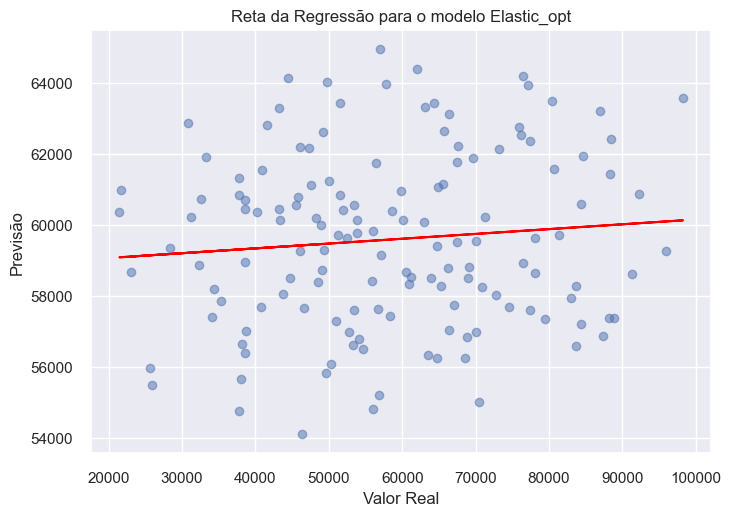

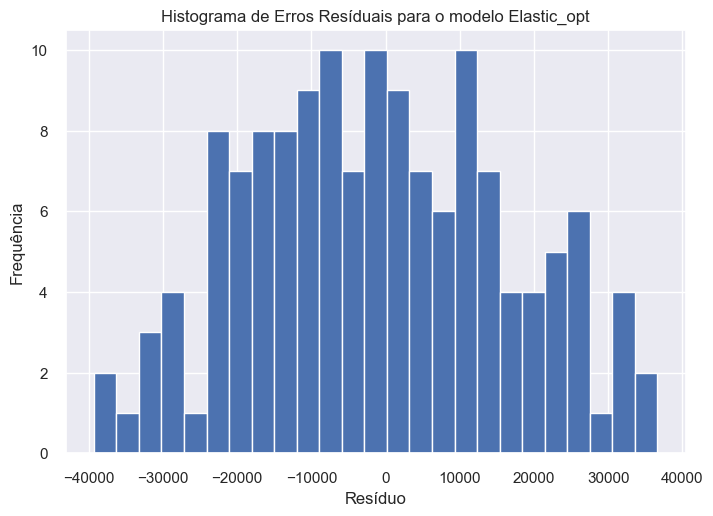

2023-04-19 09:58:46,442 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/19 09:58:46 INFO mlflow.tracking.fluent: Experiment with name 'Modelos com hiperparâmetros tunados - treino e validação' does not exist. Creating a new experiment.


Modelo:  Elastic_opt
R2 CV:   0.00
RMSE CV: 17257.39
MAPE CV: 28.51%


2023-04-19 09:58:50,158 - Ciclo de vida dos modelos rastreado com sucesso!


CPU times: total: 734 ms
Wall time: 4.57 s


In [38]:
%%time
# Retreinando modelo otimizado com novos hiperparâmetros
Elastic_opt = ElasticNet(alpha=2.0, l1_ratio=0.1, fit_intercept=True, max_iter=100, tol=0.001)

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Elastic_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=Elastic_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### Lasso

2023-04-18 15:44:46,177 - Função train_validation_eval iniciada
2023-04-18 15:44:46,178 - Iniciando loop de validação cruzada
2023-04-18 15:44:46,182 - Treinando Lasso_opt com parâmetros otimizados pelo GridSearch, fold 1
2023-04-18 15:44:49,069 - Prevendo conjunto de validação com Lasso_opt otimizado, fold 1
2023-04-18 15:44:49,070 - Avaliando resultados nos dados de validação
2023-04-18 15:44:49,073 - Treinando Lasso_opt com parâmetros otimizados pelo GridSearch, fold 2
2023-04-18 15:44:50,707 - Prevendo conjunto de validação com Lasso_opt otimizado, fold 2
2023-04-18 15:44:50,708 - Avaliando resultados nos dados de validação
2023-04-18 15:44:50,712 - Treinando Lasso_opt com parâmetros otimizados pelo GridSearch, fold 3
2023-04-18 15:44:53,674 - Prevendo conjunto de validação com Lasso_opt otimizado, fold 3
2023-04-18 15:44:53,677 - Avaliando resultados nos dados de validação
2023-04-18 15:44:53,681 - Treinando Lasso_opt com parâmetros otimizados pelo GridSearch, fold 4
2023-04-18 15

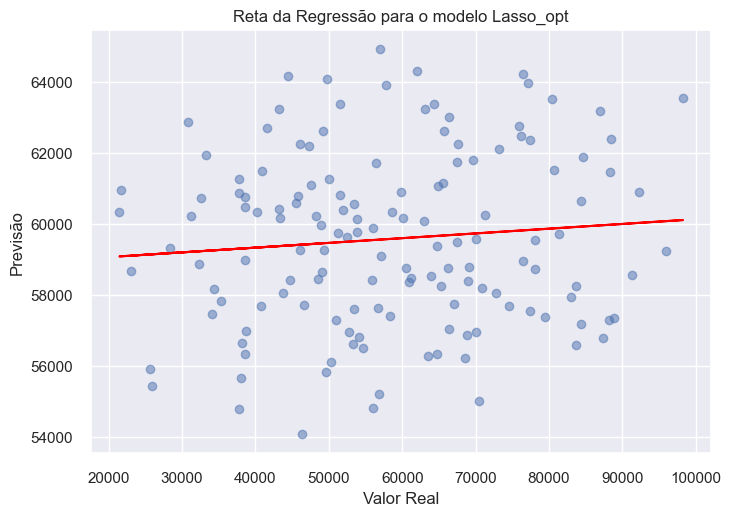

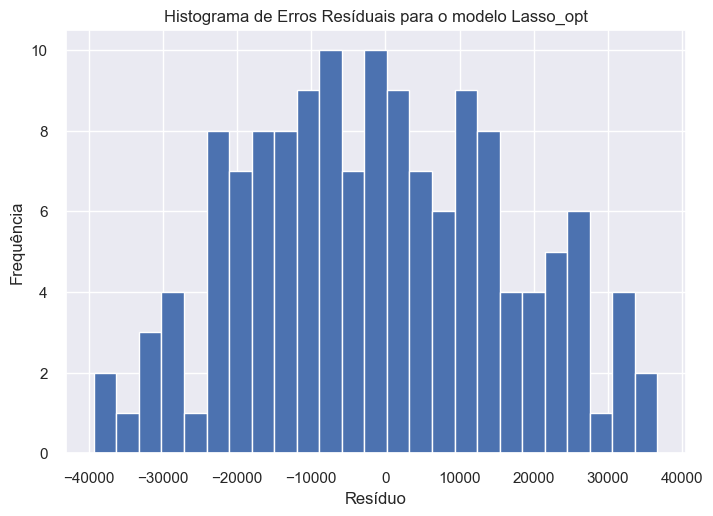

2023-04-18 15:44:58,076 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso_opt
R2 CV:   0.00
RMSE CV: 17272.06
MAPE CV: 28.53%
Melhores parâmetros: {'alpha': 100, 'fit_intercept': True, 'max_iter': 1000, 'selection': 'random', 'tol': 0.001}
Melhor modelo: Lasso(alpha=100, random_state=42, selection='random', tol=0.001)


2023-04-18 15:45:02,523 - Ciclo de vida dos modelos rastreado com sucesso!


In [67]:
# definir algoritmo a ser otimizado
lasso_opt = Lasso(random_state=42)

# define os hiperparâmetros a serem testados
params = {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
            'fit_intercept': [True, False],
            'max_iter': [1000, 5000, 10000],
            'selection':['cyclic', 'random'],
            'tol': [1e-3, 1e-4, 1e-5]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Lasso_opt'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=lasso_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-19 09:58:50,174 - Função train_validation_eval iniciada
2023-04-19 09:58:50,175 - Iniciando loop de validação cruzada
2023-04-19 09:58:50,180 - Treinando Lasso_opt com parâmetros padrão, fold 1
2023-04-19 09:58:50,185 - Prevendo conjunto de validação com Lasso_opt padrão, fold 1
2023-04-19 09:58:50,188 - Avaliando resultados nos dados de validação
2023-04-19 09:58:50,191 - Treinando Lasso_opt com parâmetros padrão, fold 2
2023-04-19 09:58:50,195 - Prevendo conjunto de validação com Lasso_opt padrão, fold 2
2023-04-19 09:58:50,197 - Avaliando resultados nos dados de validação
2023-04-19 09:58:50,201 - Treinando Lasso_opt com parâmetros padrão, fold 3
2023-04-19 09:58:50,205 - Prevendo conjunto de validação com Lasso_opt padrão, fold 3
2023-04-19 09:58:50,207 - Avaliando resultados nos dados de validação
2023-04-19 09:58:50,210 - Treinando Lasso_opt com parâmetros padrão, fold 4
2023-04-19 09:58:50,214 - Prevendo conjunto de validação com Lasso_opt padrão, fold 4
2023-04-19 09:58

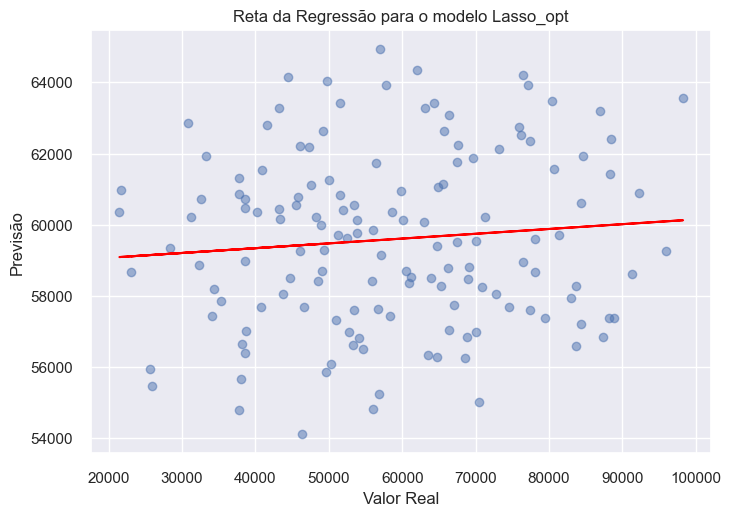

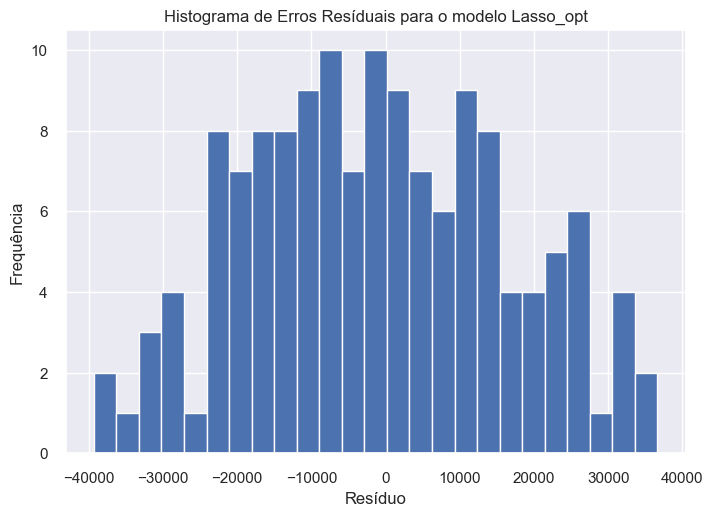

2023-04-19 09:58:51,301 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  Lasso_opt
R2 CV:   0.00
RMSE CV: 17270.61
MAPE CV: 28.53%


2023-04-19 09:58:54,960 - Ciclo de vida dos modelos rastreado com sucesso!


In [39]:
# Retreinando modelo otimizado com novos hiperparâmetros
lasso_opt = Lasso(**{'alpha': 100, 'fit_intercept': True, 'max_iter': 1000, 'selection': 'random', 'tol': 1e-05})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Lasso_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=lasso_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### LinearRegression

2023-04-18 15:44:32,132 - Função train_validation_eval iniciada
2023-04-18 15:44:32,134 - Iniciando loop de validação cruzada
2023-04-18 15:44:32,138 - Treinando LinearRegression_opt com parâmetros otimizados pelo GridSearch, fold 1
2023-04-18 15:44:36,835 - Prevendo conjunto de validação com LinearRegression_opt otimizado, fold 1
2023-04-18 15:44:36,838 - Avaliando resultados nos dados de validação
2023-04-18 15:44:36,842 - Treinando LinearRegression_opt com parâmetros otimizados pelo GridSearch, fold 2
2023-04-18 15:44:36,884 - Prevendo conjunto de validação com LinearRegression_opt otimizado, fold 2
2023-04-18 15:44:36,885 - Avaliando resultados nos dados de validação
2023-04-18 15:44:36,888 - Treinando LinearRegression_opt com parâmetros otimizados pelo GridSearch, fold 3
2023-04-18 15:44:36,923 - Prevendo conjunto de validação com LinearRegression_opt otimizado, fold 3
2023-04-18 15:44:36,925 - Avaliando resultados nos dados de validação
2023-04-18 15:44:36,928 - Treinando LinearR

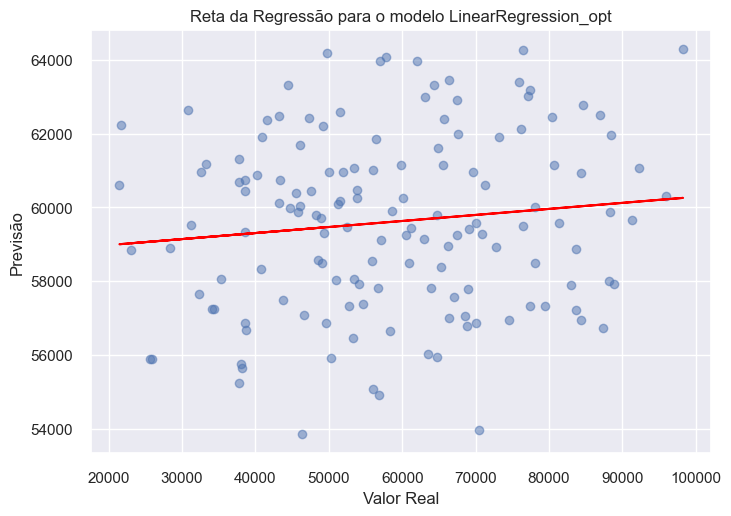

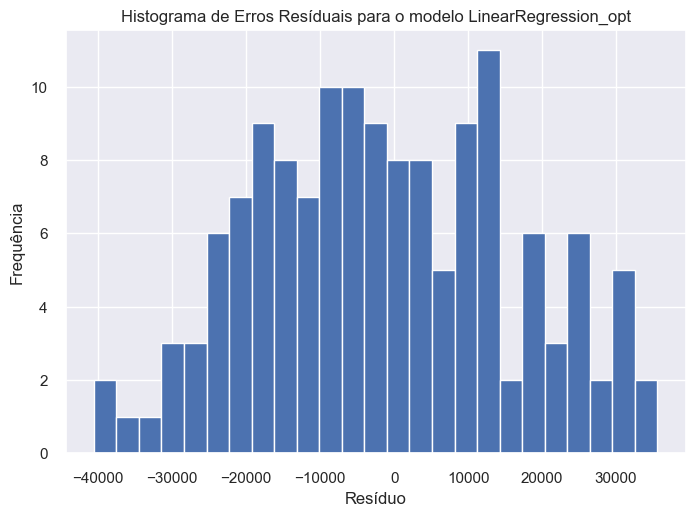

2023-04-18 15:44:37,789 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  LinearRegression_opt
R2 CV:   0.00
RMSE CV: 17242.57
MAPE CV: 28.49%
Melhores parâmetros: {'fit_intercept': True, 'positive': True}
Melhor modelo: LinearRegression(n_jobs=-1, positive=True)


2023-04-18 15:44:41,547 - Ciclo de vida dos modelos rastreado com sucesso!


In [65]:
# definir algoritmo a ser otimizado
linear_regression_opt = LinearRegression(n_jobs=-1)

# define os hiperparâmetros a serem testados
params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'LinearRegression_opt'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=linear_regression_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-19 09:58:54,977 - Função train_validation_eval iniciada
2023-04-19 09:58:54,979 - Iniciando loop de validação cruzada
2023-04-19 09:58:54,982 - Treinando LinearRegression_opt com parâmetros padrão, fold 1
2023-04-19 09:58:54,987 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 1
2023-04-19 09:58:54,989 - Avaliando resultados nos dados de validação
2023-04-19 09:58:54,993 - Treinando LinearRegression_opt com parâmetros padrão, fold 2
2023-04-19 09:58:54,998 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 2
2023-04-19 09:58:55,001 - Avaliando resultados nos dados de validação
2023-04-19 09:58:55,004 - Treinando LinearRegression_opt com parâmetros padrão, fold 3
2023-04-19 09:58:55,009 - Prevendo conjunto de validação com LinearRegression_opt padrão, fold 3
2023-04-19 09:58:55,011 - Avaliando resultados nos dados de validação
2023-04-19 09:58:55,015 - Treinando LinearRegression_opt com parâmetros padrão, fold 4
2023-04-19 09:58:55,019 -

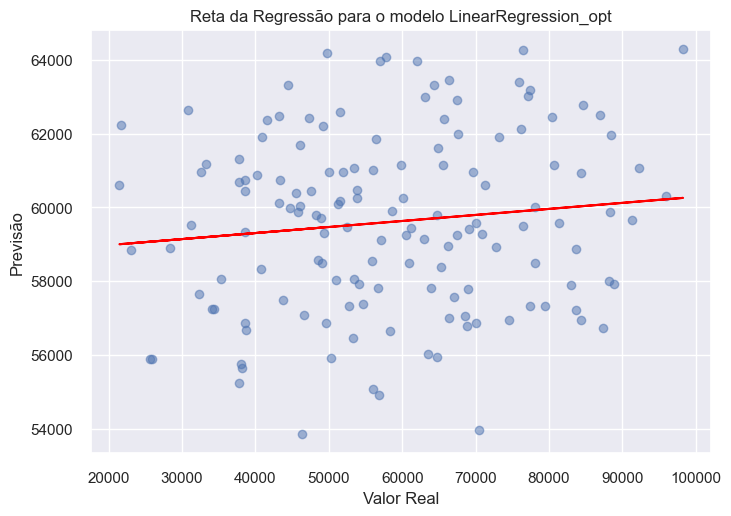

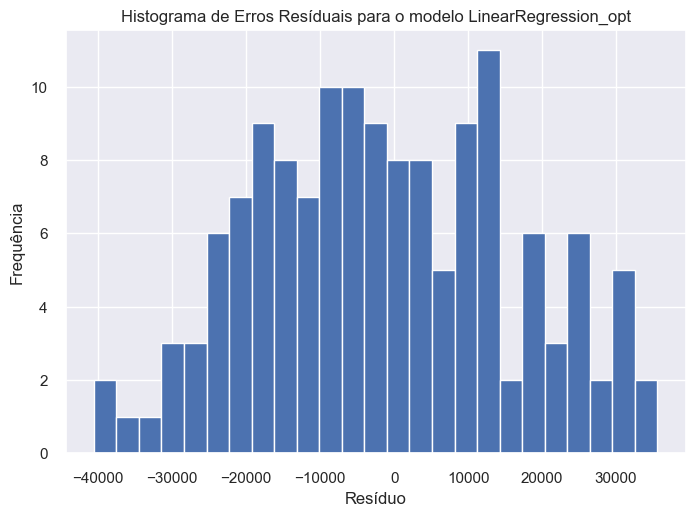

2023-04-19 09:58:55,820 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  LinearRegression_opt
R2 CV:   0.00
RMSE CV: 17242.57
MAPE CV: 28.49%


2023-04-19 09:58:59,783 - Ciclo de vida dos modelos rastreado com sucesso!


In [40]:
# Retreinando modelo otimizado com novos hiperparâmetros
linear_regression_opt = LinearRegression(**{'fit_intercept': True, 'positive': True})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'LinearRegression_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=linear_regression_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### RandomForestRegressor

2023-04-19 09:58:59,807 - Função train_validation_eval iniciada
2023-04-19 09:58:59,809 - Iniciando loop de validação cruzada
2023-04-19 09:58:59,812 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 1
2023-04-19 09:59:00,085 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 1
2023-04-19 09:59:00,099 - Avaliando resultados nos dados de validação
2023-04-19 09:59:00,102 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 2
2023-04-19 09:59:00,357 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 2
2023-04-19 09:59:00,371 - Avaliando resultados nos dados de validação
2023-04-19 09:59:00,375 - Treinando RandomForestRegressor_opt com parâmetros padrão, fold 3
2023-04-19 09:59:00,639 - Prevendo conjunto de validação com RandomForestRegressor_opt padrão, fold 3
2023-04-19 09:59:00,652 - Avaliando resultados nos dados de validação
2023-04-19 09:59:00,656 - Treinando RandomForestRegressor_opt com parâmetros padrã

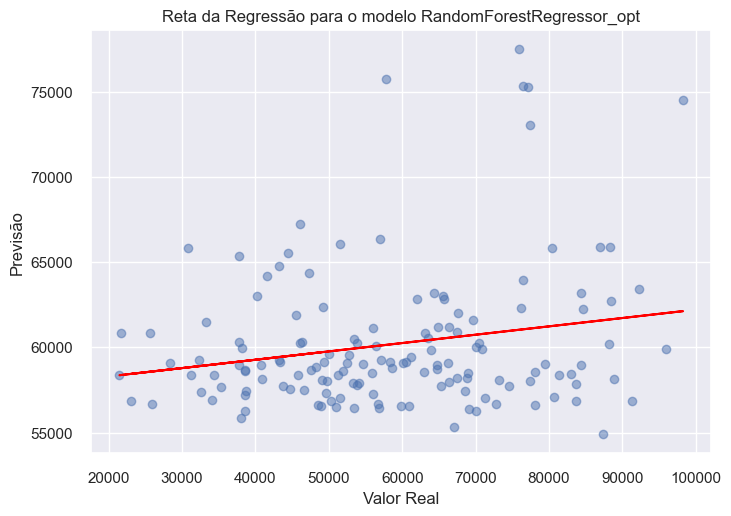

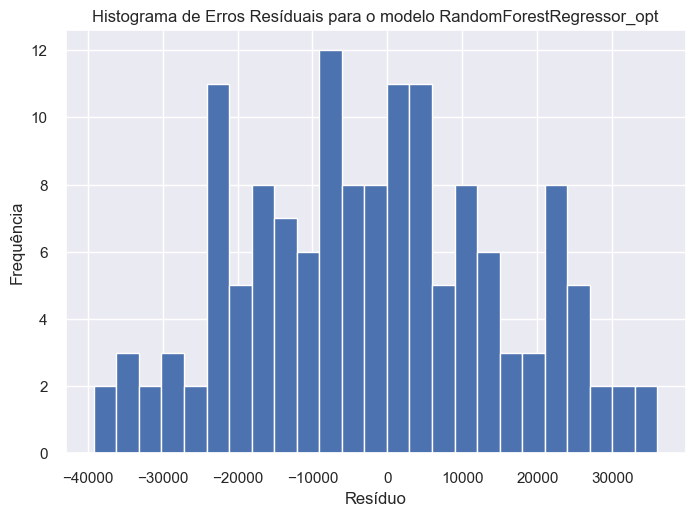

2023-04-19 09:59:01,950 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  RandomForestRegressor_opt
R2 CV:   0.00
RMSE CV: 17246.87
MAPE CV: 28.47%


2023-04-19 09:59:05,789 - Ciclo de vida dos modelos rastreado com sucesso!


In [41]:
# modelo otimizado com novos hiperparâmetros
rfr_opt = RandomForestRegressor(bootstrap=True, max_depth=5, max_features='sqrt', n_estimators=200, random_state=42, min_samples_leaf=1, min_samples_split=2)

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=rfr_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### XGBOOST

2023-04-18 15:24:21,077 - Função train_validation_eval iniciada
2023-04-18 15:24:21,078 - Iniciando loop de validação cruzada
2023-04-18 15:24:21,082 - Treinando xgboost_opt com parâmetros otimizados pelo GridSearch, fold 1
2023-04-18 15:26:28,189 - Prevendo conjunto de validação com xgboost_opt otimizado, fold 1
2023-04-18 15:26:28,193 - Avaliando resultados nos dados de validação
2023-04-18 15:26:28,197 - Treinando xgboost_opt com parâmetros otimizados pelo GridSearch, fold 2
2023-04-18 15:28:32,061 - Prevendo conjunto de validação com xgboost_opt otimizado, fold 2
2023-04-18 15:28:32,064 - Avaliando resultados nos dados de validação
2023-04-18 15:28:32,068 - Treinando xgboost_opt com parâmetros otimizados pelo GridSearch, fold 3
2023-04-18 15:30:17,115 - Prevendo conjunto de validação com xgboost_opt otimizado, fold 3
2023-04-18 15:30:17,118 - Avaliando resultados nos dados de validação
2023-04-18 15:30:17,122 - Treinando xgboost_opt com parâmetros otimizados pelo GridSearch, fold 4

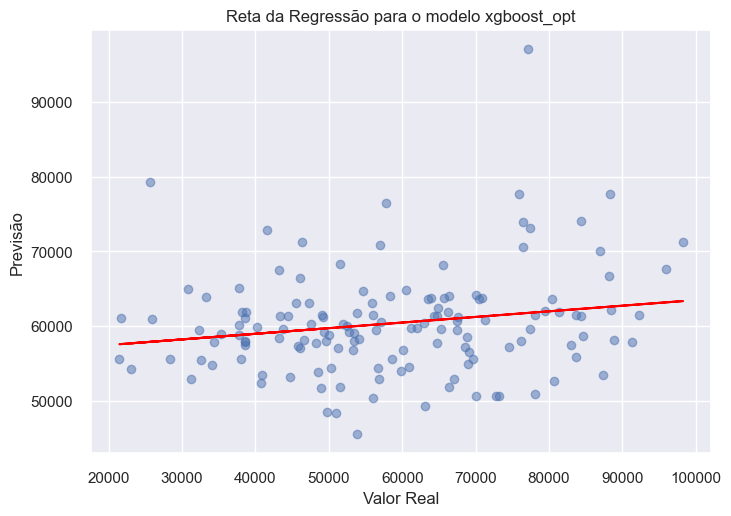

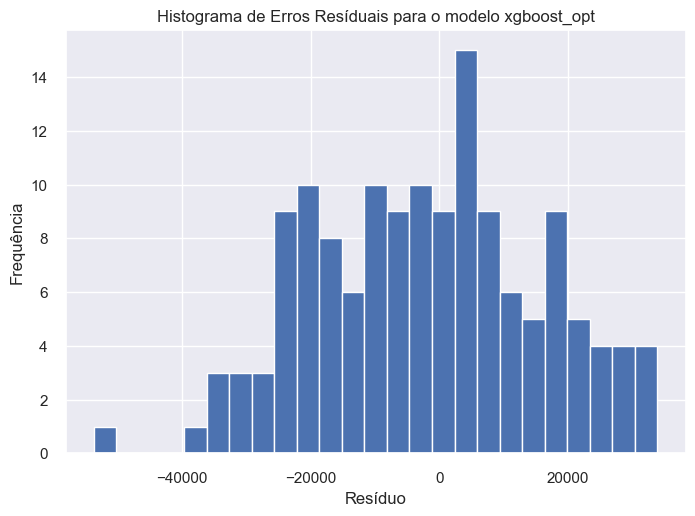

2023-04-18 15:34:00,732 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/18 15:34:00 INFO mlflow.tracking.fluent: Experiment with name 'Modelos com hiperparâmetros tunados - treino e validação' does not exist. Creating a new experiment.


Modelo:  xgboost_opt
R2 CV:   -0.04
RMSE CV: 17639.02
MAPE CV: 29.01%
Melhores parâmetros: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}
Melhor modelo: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


2023-04-18 15:34:04,437 - Ciclo de vida dos modelos rastreado com sucesso!


CPU times: total: 3min 5s
Wall time: 9min 43s


In [62]:
%%time
# definir algoritmo a ser otimizado
xgboost_opt = XGBRegressor(eval_metric='rmse', n_jobs=-1)

# define os hiperparâmetros a serem testados
params = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 3, 5],
    "learning_rate": [0.1, 0.01, 0.001],
    "gamma": [0, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [0, 0.1, 1.0]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'xgboost_opt'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=xgboost_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-19 09:59:05,801 - Função train_validation_eval iniciada
2023-04-19 09:59:05,802 - Iniciando loop de validação cruzada
2023-04-19 09:59:05,806 - Treinando xgboost_opt com parâmetros padrão, fold 1
2023-04-19 09:59:05,887 - Prevendo conjunto de validação com xgboost_opt padrão, fold 1
2023-04-19 09:59:05,901 - Avaliando resultados nos dados de validação
2023-04-19 09:59:05,907 - Treinando xgboost_opt com parâmetros padrão, fold 2
2023-04-19 09:59:05,981 - Prevendo conjunto de validação com xgboost_opt padrão, fold 2
2023-04-19 09:59:05,986 - Avaliando resultados nos dados de validação
2023-04-19 09:59:05,990 - Treinando xgboost_opt com parâmetros padrão, fold 3
2023-04-19 09:59:06,065 - Prevendo conjunto de validação com xgboost_opt padrão, fold 3
2023-04-19 09:59:06,069 - Avaliando resultados nos dados de validação
2023-04-19 09:59:06,072 - Treinando xgboost_opt com parâmetros padrão, fold 4
2023-04-19 09:59:06,146 - Prevendo conjunto de validação com xgboost_opt padrão, fold 4


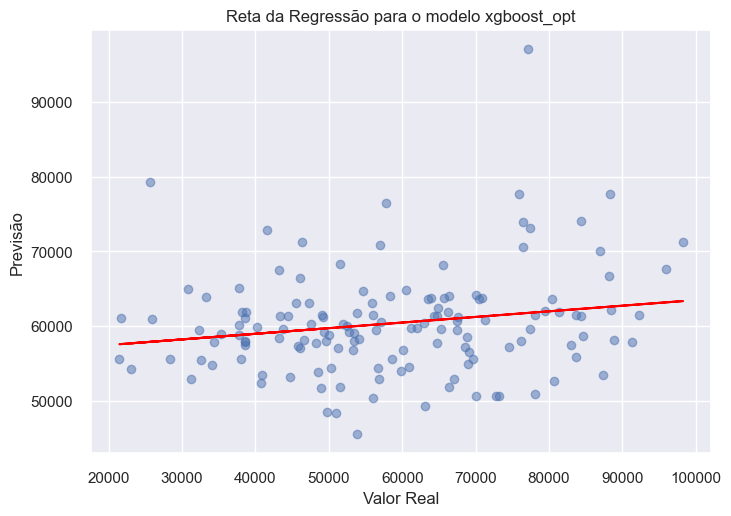

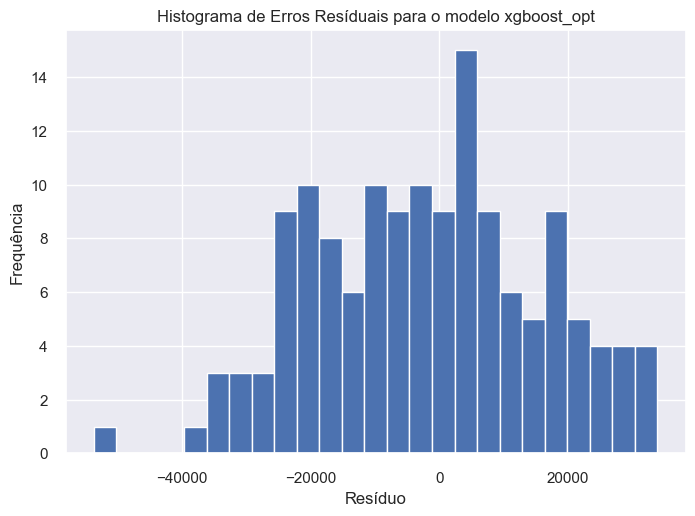

2023-04-19 09:59:07,052 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  xgboost_opt
R2 CV:   -0.04
RMSE CV: 17610.55
MAPE CV: 28.98%


2023-04-19 09:59:10,805 - Ciclo de vida dos modelos rastreado com sucesso!


In [42]:
# Retreinando modelo otimizado com novos hiperparâmetros
xgboost_opt = XGBRegressor(**{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'xgboost_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=xgboost_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### LIGHTGBM

2023-04-18 15:57:14,828 - Função train_validation_eval iniciada
2023-04-18 15:57:14,829 - Iniciando loop de validação cruzada
2023-04-18 15:57:14,832 - Treinando lgbm_opt com parâmetros otimizados pelo GridSearch, fold 1
2023-04-18 16:03:10,856 - Prevendo conjunto de validação com lgbm_opt otimizado, fold 1
2023-04-18 16:03:10,862 - Avaliando resultados nos dados de validação
2023-04-18 16:03:10,866 - Treinando lgbm_opt com parâmetros otimizados pelo GridSearch, fold 2
2023-04-18 16:09:02,683 - Prevendo conjunto de validação com lgbm_opt otimizado, fold 2
2023-04-18 16:09:02,687 - Avaliando resultados nos dados de validação
2023-04-18 16:09:02,692 - Treinando lgbm_opt com parâmetros otimizados pelo GridSearch, fold 3
2023-04-18 16:15:12,183 - Prevendo conjunto de validação com lgbm_opt otimizado, fold 3
2023-04-18 16:15:12,193 - Avaliando resultados nos dados de validação
2023-04-18 16:15:12,199 - Treinando lgbm_opt com parâmetros otimizados pelo GridSearch, fold 4
2023-04-18 16:21:13,

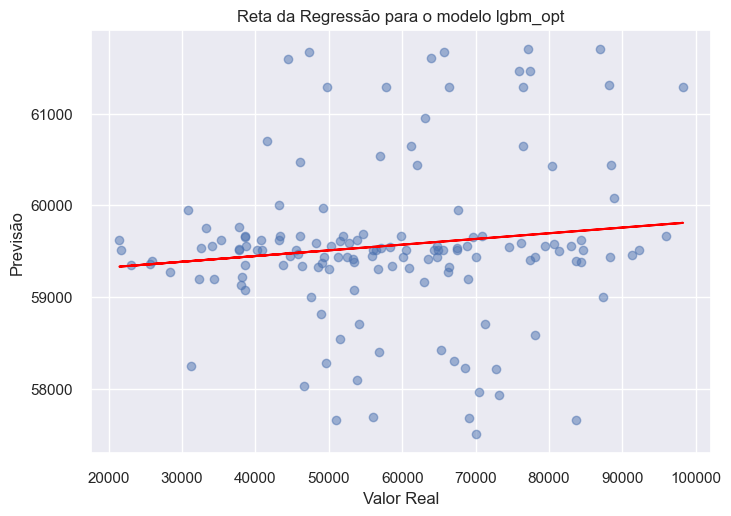

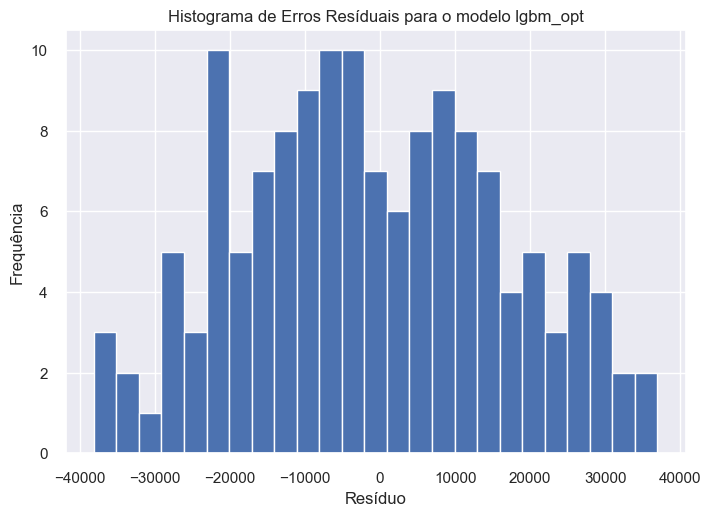

2023-04-18 16:27:15,192 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  lgbm_opt
R2 CV:   -0.00
RMSE CV: 17281.62
MAPE CV: 28.63%
Melhores parâmetros: {'learning_rate': 0.001, 'max_depth': 7, 'min_child_samples': 5, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 1.0, 'reg_lambda': 0}
Melhor modelo: LGBMRegressor(learning_rate=0.001, max_depth=7, min_child_samples=5,
              objective='regression', reg_alpha=1.0, reg_lambda=0)


2023-04-18 16:27:19,249 - Ciclo de vida dos modelos rastreado com sucesso!


CPU times: total: 3min 24s
Wall time: 30min 4s


In [71]:
%%time
# definir algoritmo a ser otimizado
lgbm_opt =LGBMRegressor(objective="regression", n_jobs=-1)

# define os hiperparâmetros a serem testados
params = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 500, 1000],
    "num_leaves": [31, 63, 127],
    "min_child_samples": [1, 3, 5],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [0, 0.1, 1.0]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'lgbm_opt'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=lgbm_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-19 09:59:10,822 - Função train_validation_eval iniciada
2023-04-19 09:59:10,823 - Iniciando loop de validação cruzada
2023-04-19 09:59:10,829 - Treinando lgbm_opt com parâmetros padrão, fold 1
2023-04-19 09:59:10,937 - Prevendo conjunto de validação com lgbm_opt padrão, fold 1
2023-04-19 09:59:10,940 - Avaliando resultados nos dados de validação
2023-04-19 09:59:10,951 - Treinando lgbm_opt com parâmetros padrão, fold 2
2023-04-19 09:59:11,071 - Prevendo conjunto de validação com lgbm_opt padrão, fold 2
2023-04-19 09:59:11,077 - Avaliando resultados nos dados de validação
2023-04-19 09:59:11,085 - Treinando lgbm_opt com parâmetros padrão, fold 3
2023-04-19 09:59:11,181 - Prevendo conjunto de validação com lgbm_opt padrão, fold 3
2023-04-19 09:59:11,191 - Avaliando resultados nos dados de validação
2023-04-19 09:59:11,197 - Treinando lgbm_opt com parâmetros padrão, fold 4
2023-04-19 09:59:11,281 - Prevendo conjunto de validação com lgbm_opt padrão, fold 4
2023-04-19 09:59:11,284 

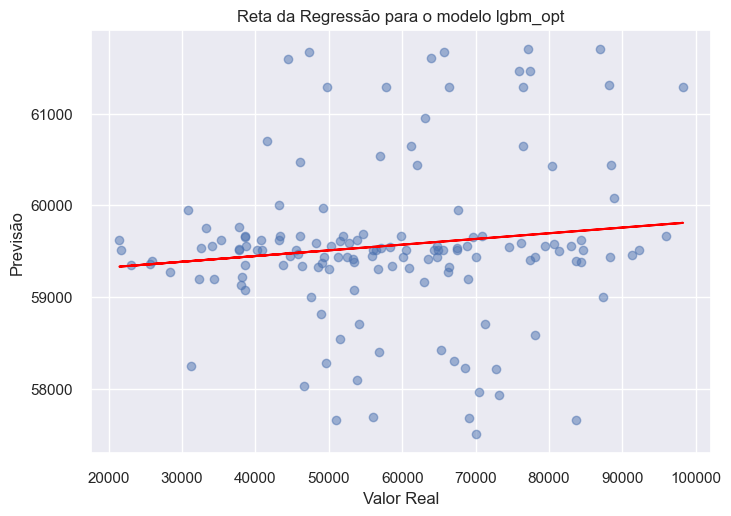

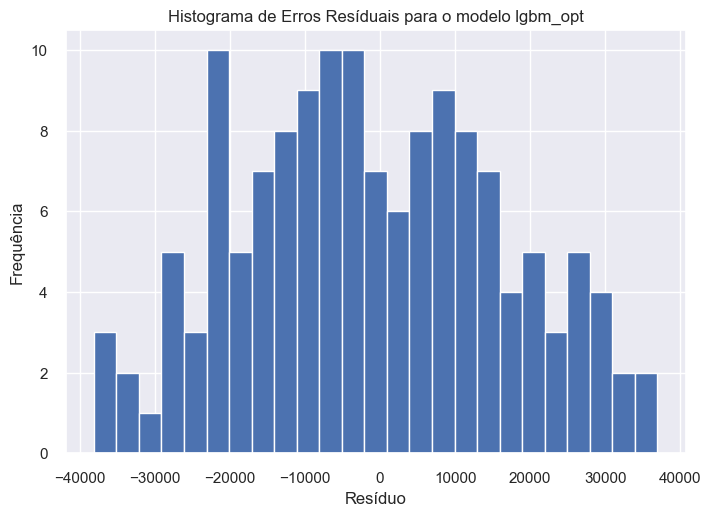

2023-04-19 09:59:12,268 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  lgbm_opt
R2 CV:   -0.00
RMSE CV: 17315.27
MAPE CV: 28.68%


2023-04-19 09:59:16,274 - Ciclo de vida dos modelos rastreado com sucesso!


In [43]:
# Retreinando modelo otimizado com novos hiperparâmetros
lgbm_opt =LGBMRegressor(**{'learning_rate': 0.001, 'max_depth': 7, 'min_child_samples': 5, 'n_estimators': 100, 'num_leaves': 31, 'reg_alpha': 1.0, 'reg_lambda': 0})

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'lgbm_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=lgbm_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

#### CATBOOST

2023-04-18 21:11:28,513 - Função train_validation_eval iniciada
2023-04-18 21:11:28,514 - Iniciando loop de validação cruzada
2023-04-18 21:11:28,518 - Treinando catboost_opt com parâmetros otimizados pelo GridSearch, fold 1


0:	learn: 17633.3093453	total: 1.11ms	remaining: 1.11s
1:	learn: 17632.0555610	total: 2ms	remaining: 997ms
2:	learn: 17630.5726016	total: 2.82ms	remaining: 936ms
3:	learn: 17628.7943187	total: 3.69ms	remaining: 920ms
4:	learn: 17627.2093282	total: 4.59ms	remaining: 913ms
5:	learn: 17626.1749650	total: 5.45ms	remaining: 903ms
6:	learn: 17624.5893425	total: 6.3ms	remaining: 894ms
7:	learn: 17623.3797150	total: 7.13ms	remaining: 884ms
8:	learn: 17621.7901431	total: 7.94ms	remaining: 875ms
9:	learn: 17620.0167220	total: 8.91ms	remaining: 882ms
10:	learn: 17618.2426700	total: 9.8ms	remaining: 881ms
11:	learn: 17616.4888455	total: 10.9ms	remaining: 894ms
12:	learn: 17614.7122254	total: 11.8ms	remaining: 893ms
13:	learn: 17612.9351343	total: 12.7ms	remaining: 892ms
14:	learn: 17611.1733830	total: 13.5ms	remaining: 889ms
15:	learn: 17609.5774470	total: 14.6ms	remaining: 895ms
16:	learn: 17608.3998399	total: 15.6ms	remaining: 901ms
17:	learn: 17607.0410710	total: 16.5ms	remaining: 901ms
18:	lea

2023-04-18 21:30:24,678 - Prevendo conjunto de validação com catboost_opt otimizado, fold 1
2023-04-18 21:30:24,681 - Avaliando resultados nos dados de validação
2023-04-18 21:30:24,685 - Treinando catboost_opt com parâmetros otimizados pelo GridSearch, fold 2


948:	learn: 16657.2134328	total: 895ms	remaining: 48.1ms
949:	learn: 16656.3975908	total: 896ms	remaining: 47.2ms
950:	learn: 16655.6569173	total: 897ms	remaining: 46.2ms
951:	learn: 16654.8598955	total: 898ms	remaining: 45.3ms
952:	learn: 16653.9602621	total: 899ms	remaining: 44.4ms
953:	learn: 16653.2355522	total: 900ms	remaining: 43.4ms
954:	learn: 16652.3627789	total: 901ms	remaining: 42.5ms
955:	learn: 16651.7831004	total: 902ms	remaining: 41.5ms
956:	learn: 16651.1648146	total: 903ms	remaining: 40.6ms
957:	learn: 16650.2016289	total: 904ms	remaining: 39.6ms
958:	learn: 16649.5188855	total: 905ms	remaining: 38.7ms
959:	learn: 16648.9382149	total: 906ms	remaining: 37.7ms
960:	learn: 16648.2833840	total: 907ms	remaining: 36.8ms
961:	learn: 16647.6412051	total: 908ms	remaining: 35.9ms
962:	learn: 16646.9029515	total: 909ms	remaining: 34.9ms
963:	learn: 16646.1020007	total: 910ms	remaining: 34ms
964:	learn: 16645.2041556	total: 911ms	remaining: 33ms
965:	learn: 16644.5455977	total: 91

2023-04-18 21:44:21,589 - Prevendo conjunto de validação com catboost_opt otimizado, fold 2
2023-04-18 21:44:21,592 - Avaliando resultados nos dados de validação
2023-04-18 21:44:21,597 - Treinando catboost_opt com parâmetros otimizados pelo GridSearch, fold 3


0:	learn: 17530.4230409	total: 1.3ms	remaining: 129ms
1:	learn: 17522.3243921	total: 2.7ms	remaining: 132ms
2:	learn: 17520.4531109	total: 3.82ms	remaining: 123ms
3:	learn: 17515.0374966	total: 4.85ms	remaining: 116ms
4:	learn: 17510.4135849	total: 6.01ms	remaining: 114ms
5:	learn: 17506.6846622	total: 7.13ms	remaining: 112ms
6:	learn: 17498.6815654	total: 8.32ms	remaining: 111ms
7:	learn: 17493.9725799	total: 9.44ms	remaining: 109ms
8:	learn: 17491.1435870	total: 10.5ms	remaining: 106ms
9:	learn: 17486.4136530	total: 11.5ms	remaining: 103ms
10:	learn: 17483.4319269	total: 12.4ms	remaining: 101ms
11:	learn: 17474.2621562	total: 13.4ms	remaining: 98.2ms
12:	learn: 17468.1098007	total: 14.5ms	remaining: 96.9ms
13:	learn: 17461.1770909	total: 15.4ms	remaining: 94.8ms
14:	learn: 17457.0292142	total: 16.5ms	remaining: 93.3ms
15:	learn: 17452.2697505	total: 17.5ms	remaining: 91.7ms
16:	learn: 17447.6811753	total: 18.4ms	remaining: 90ms
17:	learn: 17445.0498382	total: 19.9ms	remaining: 90.8ms

2023-04-18 21:58:25,235 - Prevendo conjunto de validação com catboost_opt otimizado, fold 3
2023-04-18 21:58:25,238 - Avaliando resultados nos dados de validação
2023-04-18 21:58:25,241 - Treinando catboost_opt com parâmetros otimizados pelo GridSearch, fold 4


959:	learn: 16649.0248882	total: 501ms	remaining: 20.9ms
960:	learn: 16648.6980619	total: 502ms	remaining: 20.4ms
961:	learn: 16648.2127005	total: 503ms	remaining: 19.9ms
962:	learn: 16647.6410011	total: 503ms	remaining: 19.3ms
963:	learn: 16647.2798274	total: 504ms	remaining: 18.8ms
964:	learn: 16646.8615870	total: 505ms	remaining: 18.3ms
965:	learn: 16646.3968461	total: 505ms	remaining: 17.8ms
966:	learn: 16645.9761431	total: 506ms	remaining: 17.3ms
967:	learn: 16645.5694621	total: 506ms	remaining: 16.7ms
968:	learn: 16645.1545684	total: 507ms	remaining: 16.2ms
969:	learn: 16644.8380146	total: 508ms	remaining: 15.7ms
970:	learn: 16644.3935326	total: 508ms	remaining: 15.2ms
971:	learn: 16644.0631789	total: 509ms	remaining: 14.7ms
972:	learn: 16643.6884163	total: 510ms	remaining: 14.1ms
973:	learn: 16643.2868823	total: 510ms	remaining: 13.6ms
974:	learn: 16642.8892458	total: 511ms	remaining: 13.1ms
975:	learn: 16642.3890942	total: 511ms	remaining: 12.6ms
976:	learn: 16642.0728698	total

2023-04-18 22:12:24,958 - Prevendo conjunto de validação com catboost_opt otimizado, fold 4
2023-04-18 22:12:24,961 - Avaliando resultados nos dados de validação
2023-04-18 22:12:24,965 - Treinando catboost_opt com parâmetros otimizados pelo GridSearch, fold 5


0:	learn: 17043.0519776	total: 1.83ms	remaining: 181ms
1:	learn: 17038.1029370	total: 3.17ms	remaining: 156ms
2:	learn: 17033.6907441	total: 4.06ms	remaining: 131ms
3:	learn: 17025.4282245	total: 4.9ms	remaining: 118ms
4:	learn: 17018.0080559	total: 5.79ms	remaining: 110ms
5:	learn: 17010.2178066	total: 6.67ms	remaining: 104ms
6:	learn: 17003.5700913	total: 7.62ms	remaining: 101ms
7:	learn: 16994.8899618	total: 8.51ms	remaining: 97.8ms
8:	learn: 16986.4284489	total: 9.39ms	remaining: 94.9ms
9:	learn: 16979.3917269	total: 10.2ms	remaining: 91.9ms
10:	learn: 16973.4151891	total: 11ms	remaining: 89.3ms
11:	learn: 16967.2747499	total: 11.9ms	remaining: 87.1ms
12:	learn: 16960.7341347	total: 12.8ms	remaining: 85.4ms
13:	learn: 16951.2860071	total: 13.6ms	remaining: 83.5ms
14:	learn: 16945.4826137	total: 14.4ms	remaining: 81.7ms
15:	learn: 16940.5442858	total: 15.3ms	remaining: 80.1ms
16:	learn: 16933.5239088	total: 16.1ms	remaining: 78.5ms
17:	learn: 16926.3231335	total: 16.9ms	remaining: 7

2023-04-18 22:28:51,223 - Prevendo conjunto de validação com catboost_opt otimizado, fold 5
2023-04-18 22:28:51,227 - Avaliando resultados nos dados de validação


0:	learn: 17300.5871598	total: 1.63ms	remaining: 161ms
1:	learn: 17294.5332130	total: 3.02ms	remaining: 148ms
2:	learn: 17290.8314052	total: 3.95ms	remaining: 128ms
3:	learn: 17286.3151977	total: 4.91ms	remaining: 118ms
4:	learn: 17281.7763649	total: 5.86ms	remaining: 111ms
5:	learn: 17276.3220220	total: 7.05ms	remaining: 110ms
6:	learn: 17271.4305363	total: 7.95ms	remaining: 106ms
7:	learn: 17266.5678430	total: 8.88ms	remaining: 102ms
8:	learn: 17263.8138708	total: 9.77ms	remaining: 98.8ms
9:	learn: 17257.4135371	total: 10.6ms	remaining: 95.6ms
10:	learn: 17254.8007499	total: 11.4ms	remaining: 92.6ms
11:	learn: 17250.9761169	total: 12.3ms	remaining: 90.3ms
12:	learn: 17245.8268842	total: 13.3ms	remaining: 88.7ms
13:	learn: 17240.7801236	total: 14.2ms	remaining: 87.1ms
14:	learn: 17235.3417359	total: 15.1ms	remaining: 85.5ms
15:	learn: 17231.7810014	total: 16ms	remaining: 84ms
16:	learn: 17229.7856199	total: 16.9ms	remaining: 82.4ms
17:	learn: 17227.2051452	total: 17.7ms	remaining: 80.

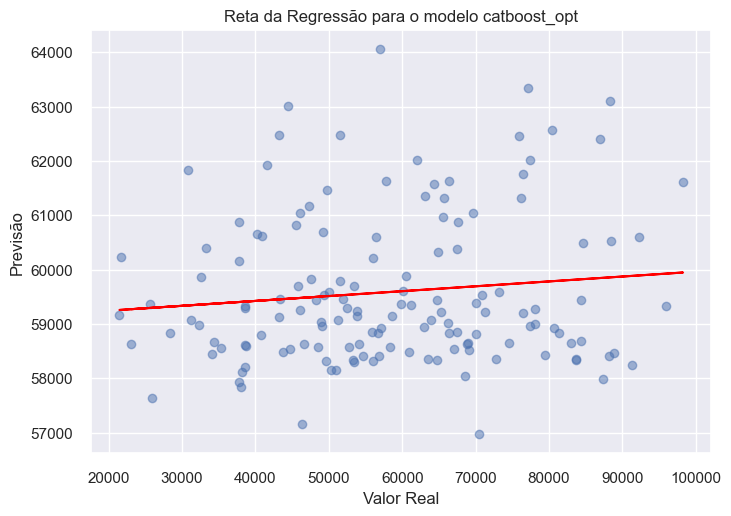

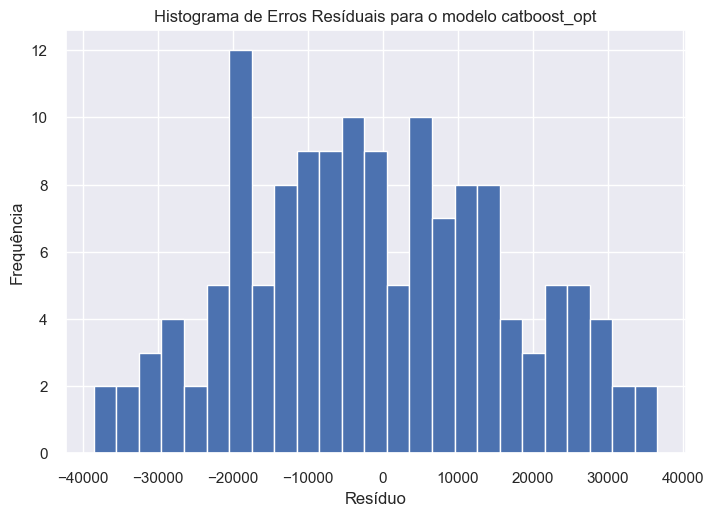

2023-04-18 22:28:52,459 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  catboost_opt
R2 CV:   -0.00
RMSE CV: 17290.91
MAPE CV: 28.60%
Melhores parâmetros: {'bagging_temperature': 0, 'depth': 5, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'random_strength': 10}
Melhor modelo: <catboost.core.CatBoostRegressor object at 0x00000293A1BB2500>


2023-04-18 22:28:56,591 - Ciclo de vida dos modelos rastreado com sucesso!


CPU times: total: 50.2 s
Wall time: 1h 17min 28s


In [74]:
%%time
# definir algoritmo a ser otimizado
catboost_opt = CatBoostRegressor(loss_function="RMSE")

# define os hiperparâmetros a serem testados
params = {
    "depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "iterations": [100, 500, 1000],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0, 1, 10],
    "random_strength": [0, 1, 10]
}

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

    
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'catboost_opt'
model_name_date = model_name + ' - ' + date
    
train_validation_eval(model_name=model_name, model=catboost_opt, X=X, y=y, gridsearch=True, params_grid=params, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

2023-04-19 09:59:16,299 - Função train_validation_eval iniciada
2023-04-19 09:59:16,300 - Iniciando loop de validação cruzada
2023-04-19 09:59:16,304 - Treinando catboost_opt com parâmetros padrão, fold 1
2023-04-19 09:59:16,426 - Prevendo conjunto de validação com catboost_opt padrão, fold 1
2023-04-19 09:59:16,429 - Avaliando resultados nos dados de validação
2023-04-19 09:59:16,434 - Treinando catboost_opt com parâmetros padrão, fold 2


0:	learn: 17632.0620945	total: 1.51ms	remaining: 150ms
1:	learn: 17625.8922751	total: 2.44ms	remaining: 120ms
2:	learn: 17624.4619813	total: 3.45ms	remaining: 112ms
3:	learn: 17619.1871093	total: 4.29ms	remaining: 103ms
4:	learn: 17615.6488058	total: 5.51ms	remaining: 105ms
5:	learn: 17612.8836352	total: 6.49ms	remaining: 102ms
6:	learn: 17609.0663472	total: 7.43ms	remaining: 98.7ms
7:	learn: 17605.4059436	total: 8.45ms	remaining: 97.2ms
8:	learn: 17602.7973421	total: 9.27ms	remaining: 93.7ms
9:	learn: 17598.5612463	total: 10.1ms	remaining: 90.9ms
10:	learn: 17594.0934642	total: 10.9ms	remaining: 88.4ms
11:	learn: 17585.7736469	total: 11.8ms	remaining: 86.6ms
12:	learn: 17581.5399994	total: 12.6ms	remaining: 84.4ms
13:	learn: 17576.6594759	total: 13.4ms	remaining: 82.4ms
14:	learn: 17570.8267387	total: 14.3ms	remaining: 80.9ms
15:	learn: 17565.6326097	total: 15.1ms	remaining: 79.2ms
16:	learn: 17562.1351004	total: 15.9ms	remaining: 77.9ms
17:	learn: 17560.0909904	total: 16.7ms	remainin

2023-04-19 09:59:16,554 - Prevendo conjunto de validação com catboost_opt padrão, fold 2
2023-04-19 09:59:16,557 - Avaliando resultados nos dados de validação
2023-04-19 09:59:16,561 - Treinando catboost_opt com parâmetros padrão, fold 3
2023-04-19 09:59:16,671 - Prevendo conjunto de validação com catboost_opt padrão, fold 3
2023-04-19 09:59:16,674 - Avaliando resultados nos dados de validação
2023-04-19 09:59:16,677 - Treinando catboost_opt com parâmetros padrão, fold 4


64:	learn: 17261.1072221	total: 50.3ms	remaining: 27.1ms
65:	learn: 17257.7798252	total: 51.4ms	remaining: 26.5ms
66:	learn: 17253.7444022	total: 52.6ms	remaining: 25.9ms
67:	learn: 17249.9003110	total: 53.8ms	remaining: 25.3ms
68:	learn: 17246.0452997	total: 54.9ms	remaining: 24.6ms
69:	learn: 17242.1591703	total: 55.8ms	remaining: 23.9ms
70:	learn: 17240.8981298	total: 56.6ms	remaining: 23.1ms
71:	learn: 17237.1919689	total: 57.3ms	remaining: 22.3ms
72:	learn: 17234.1160440	total: 58.1ms	remaining: 21.5ms
73:	learn: 17230.3113880	total: 58.8ms	remaining: 20.6ms
74:	learn: 17225.4000353	total: 59.5ms	remaining: 19.8ms
75:	learn: 17222.2170174	total: 60.5ms	remaining: 19.1ms
76:	learn: 17214.7631119	total: 61.2ms	remaining: 18.3ms
77:	learn: 17210.6018650	total: 62ms	remaining: 17.5ms
78:	learn: 17207.5327332	total: 62.7ms	remaining: 16.7ms
79:	learn: 17204.1511118	total: 63.6ms	remaining: 15.9ms
80:	learn: 17199.8970665	total: 64.5ms	remaining: 15.1ms
81:	learn: 17196.7901572	total: 6

2023-04-19 09:59:16,792 - Prevendo conjunto de validação com catboost_opt padrão, fold 4
2023-04-19 09:59:16,795 - Avaliando resultados nos dados de validação
2023-04-19 09:59:16,798 - Treinando catboost_opt com parâmetros padrão, fold 5


19:	learn: 16974.2339787	total: 17ms	remaining: 68.1ms
20:	learn: 16969.0824494	total: 18.3ms	remaining: 68.9ms
21:	learn: 16965.2327928	total: 19.1ms	remaining: 67.7ms
22:	learn: 16961.5746195	total: 20ms	remaining: 67ms
23:	learn: 16956.6689237	total: 20.9ms	remaining: 66.2ms
24:	learn: 16954.1254802	total: 21.7ms	remaining: 65.1ms
25:	learn: 16950.4233619	total: 22.4ms	remaining: 63.7ms
26:	learn: 16948.8834878	total: 23ms	remaining: 62.3ms
27:	learn: 16945.9395971	total: 23.7ms	remaining: 60.9ms
28:	learn: 16944.3831408	total: 24.4ms	remaining: 59.7ms
29:	learn: 16941.4264086	total: 25ms	remaining: 58.4ms
30:	learn: 16937.8690402	total: 25.6ms	remaining: 57ms
31:	learn: 16931.7706667	total: 26.3ms	remaining: 55.8ms
32:	learn: 16927.4097894	total: 27ms	remaining: 54.7ms
33:	learn: 16924.5131588	total: 27.6ms	remaining: 53.6ms
34:	learn: 16922.4807859	total: 28.3ms	remaining: 52.6ms
35:	learn: 16916.0451361	total: 29.1ms	remaining: 51.8ms
36:	learn: 16908.7688088	total: 30ms	remainin

2023-04-19 09:59:16,909 - Prevendo conjunto de validação com catboost_opt padrão, fold 5
2023-04-19 09:59:16,912 - Avaliando resultados nos dados de validação


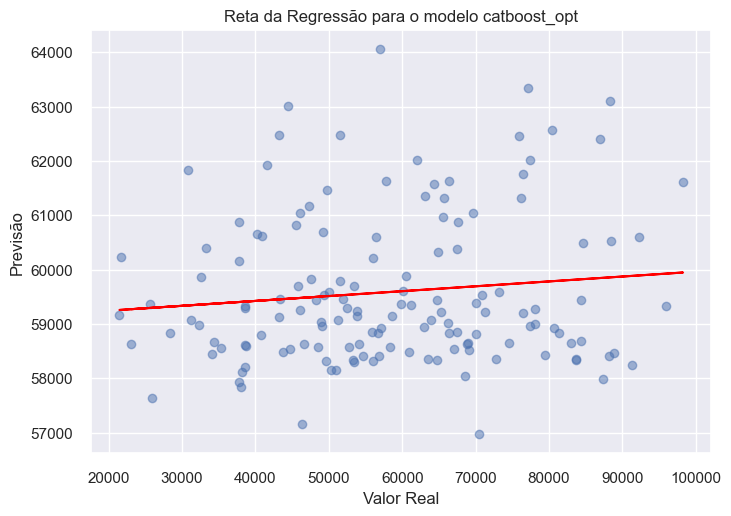

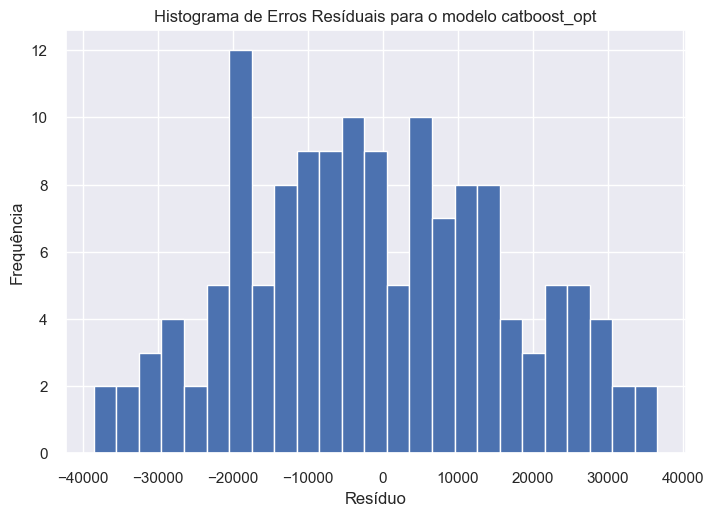

2023-04-19 09:59:17,724 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo:  catboost_opt
R2 CV:   0.00
RMSE CV: 17278.12
MAPE CV: 28.59%


2023-04-19 09:59:21,177 - Ciclo de vida dos modelos rastreado com sucesso!


In [44]:
# Retreinando modelo otimizado com novos hiperparâmetros
catboost_opt = CatBoostRegressor(**{'bagging_temperature': 0, 'depth': 5, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'random_strength': 10},loss_function="RMSE")

experiment_name = 'Modelos com hiperparâmetros tunados - treino e validação'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'catboost_opt'
model_name_date = model_name + ' - ' + date

train_validation_eval(model_name=model_name, 
                      model=catboost_opt, 
                      X=X, 
                      y=y, 
                      gridsearch=False, 
                      params_grid=None, 
                      run_name=model_name_date, 
                      experiment_name=experiment_name,
                      path_save_fig=path_save_fig)

### Modelos otimizados ranking:

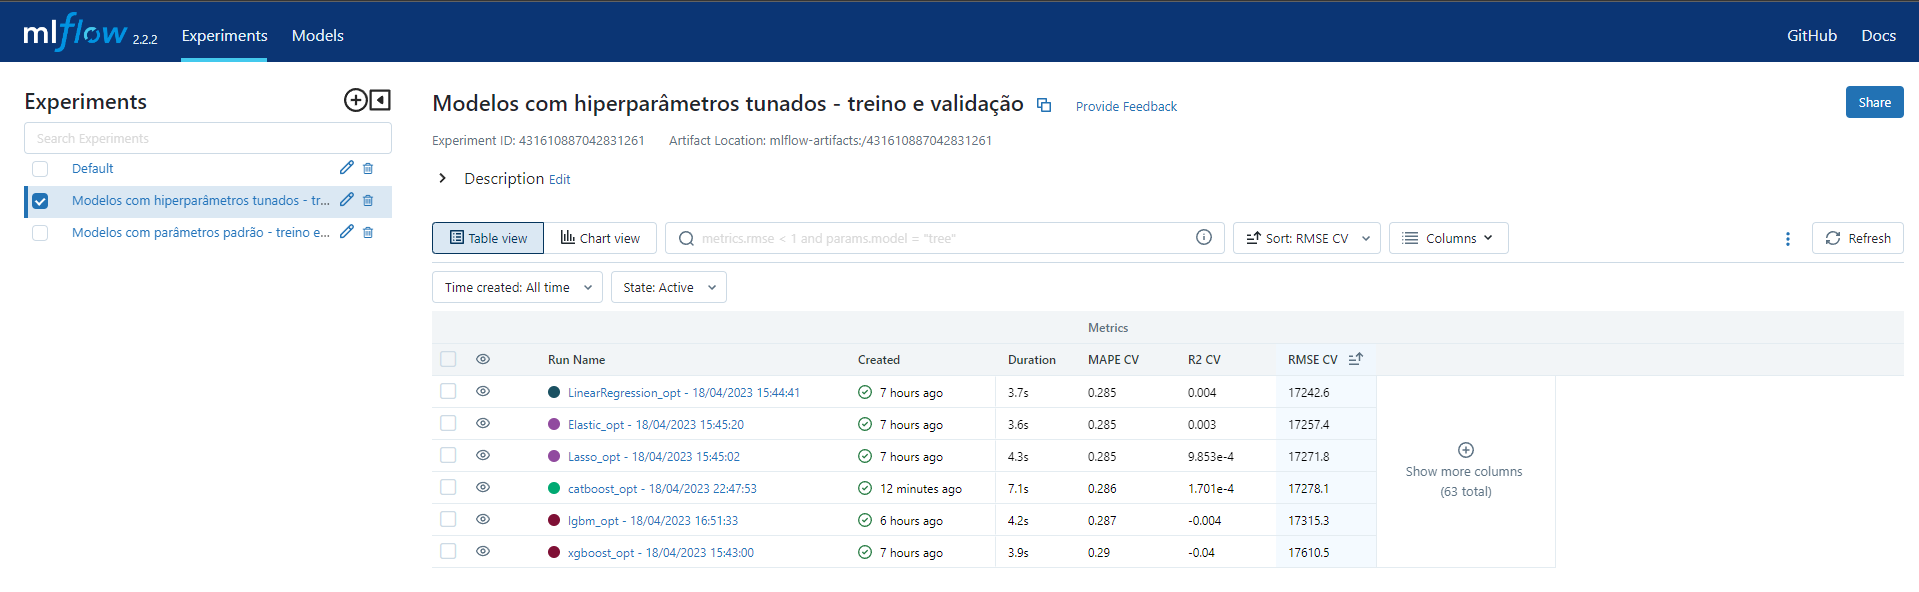

## Teste

In [45]:
# Separar variáveis independentes e dependente
X_test = df_teste.drop(['Store_Sales'], axis=1)
y_test = df_teste['Store_Sales']

In [46]:
X_test.head()

Store ID   Store_Area  Items_Available  Daily_Customer_Count
0        712        1360             1612                   490
1        441        1721             2076                   710
2        526        1001             1194                  1210
3        723        1799             2173                   910
4         40        1270             1516                    10

In [47]:
y_test

0      61080
1      76300
2      44890
3      36280
4      45480
       ...  
175    65970
176    70050
177    90180
178    71280
179    81470
Name: Store_Sales, Length: 180, dtype: int64

In [52]:
# definir função de avaliação para conjunto de teste
def test_eval(model_name, model, X_test, y_test, run_name=None, experiment_name=None, path_save_fig=None):
    
    logging.info("Prevendo conjunto de teste com modelo treinado")
    # Usar modelo treinado para previsão no conjunto de teste
    yhat = model.predict(X_test)
    
    logging.info("Avaliando resultados nos dados de teste")
    #Avaliação
    # R2
    R2 = r2_score(y_test, yhat)
    # RMSE
    RMSE = np.sqrt(mean_squared_error(y_test, yhat))
    # MAPE
    MAPE = mean_absolute_percentage_error(y_test, yhat)
    
    # Erro de previsão com a reta da regressão
    p = np.polyfit(y_test, yhat, 1)
    plt.scatter(y_test, yhat, alpha=0.5)
    plt.plot(y_test, np.polyval(p, y_test), color='red')
    plt.xlabel('Valor Real')
    plt.ylabel('Previsão')
    plt.title(f'Reta da Regressão para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
    
    # Resíduos dos erros
    residuals = y_test - yhat
    plt.hist(residuals, bins=25)
    plt.xlabel('Resíduo')
    plt.ylabel('Frequência')
    plt.title(f'Histograma de Erros Resíduais para o modelo {model_name}')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    plt.show()
   
        
    # Avaliação na validação
    print(f"Modelo: {model_name}")
    print(f"R2:     {R2:.2f}")
    print(f"RMSE:   {RMSE:.2f}")
    print(f"MAPE:   {MAPE:.2%}")
    
    logging.info("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    
    with mlflow.start_run(run_name=run_name):
        mlflow.log_metric('R2', R2)
        mlflow.log_metric('RMSE', RMSE)
        mlflow.log_metric('MAPE', MAPE)
        mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
        mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_regression_error.jpg"))
        mlflow.sklearn.log_model(model, model_name)
    mlflow.end_run()
        
    return logging.info('Ciclo de vida do modelo rastreado com sucesso!')
    

### ElasticNet otimizado

2023-04-19 10:06:06,462 - Prevendo conjunto de teste com modelo treinado
2023-04-19 10:06:06,465 - Avaliando resultados nos dados de teste


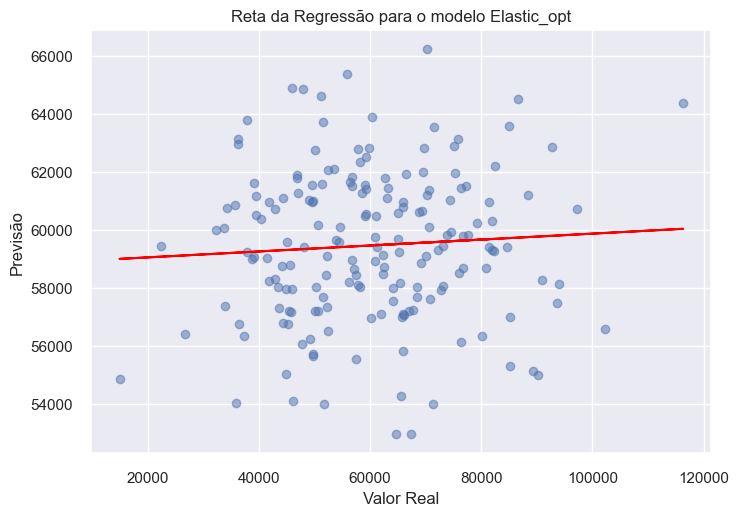

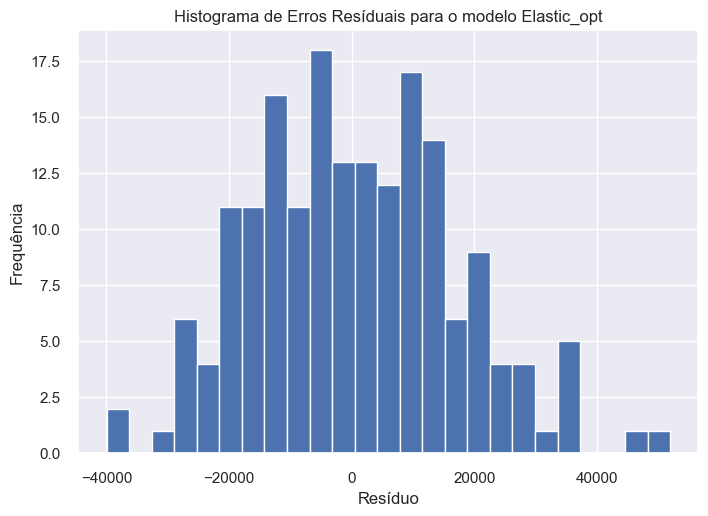

2023-04-19 10:06:07,178 - Rastreamento de resultados dos experimentos com MLFLOW iniciado
2023/04/19 10:06:07 INFO mlflow.tracking.fluent: Experiment with name 'Teste' does not exist. Creating a new experiment.


Modelo: Elastic_opt
R2:     -0.01
RMSE:   16540.79
MAPE:   25.54%


2023-04-19 10:06:10,969 - Ciclo de vida do modelo rastreado com sucesso!


In [53]:
# Melhor modelo apresentado do Sklearn

experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Elastic_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=Elastic_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### Lasso otimizado

2023-04-19 10:06:31,765 - Prevendo conjunto de teste com modelo treinado
2023-04-19 10:06:31,768 - Avaliando resultados nos dados de teste


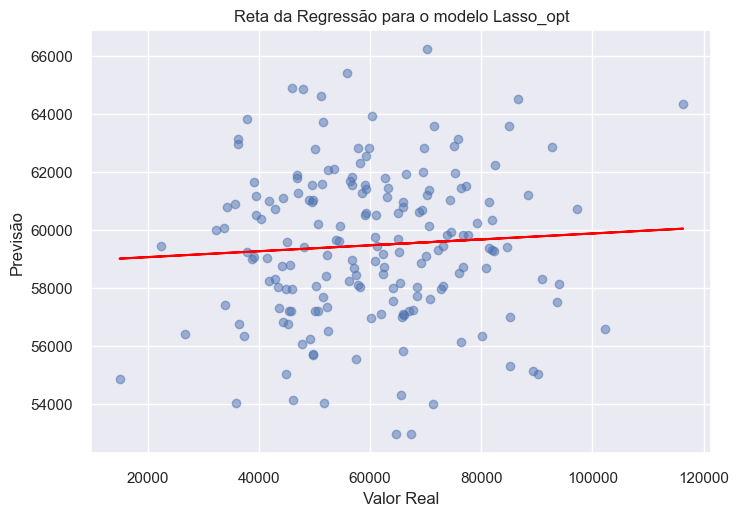

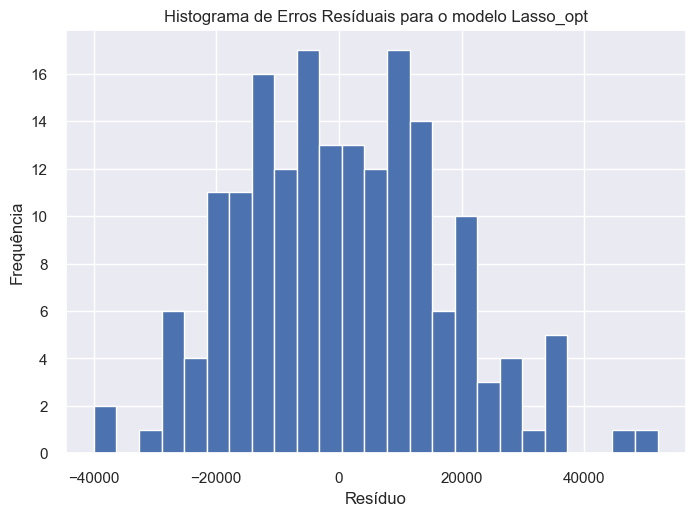

2023-04-19 10:06:32,750 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: Lasso_opt
R2:     -0.01
RMSE:   16541.63
MAPE:   25.54%


2023-04-19 10:06:36,571 - Ciclo de vida do modelo rastreado com sucesso!


In [54]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'Lasso_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=lasso_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### RandomForestRegressor otimizado

2023-04-19 10:06:36,591 - Prevendo conjunto de teste com modelo treinado
2023-04-19 10:06:36,609 - Avaliando resultados nos dados de teste


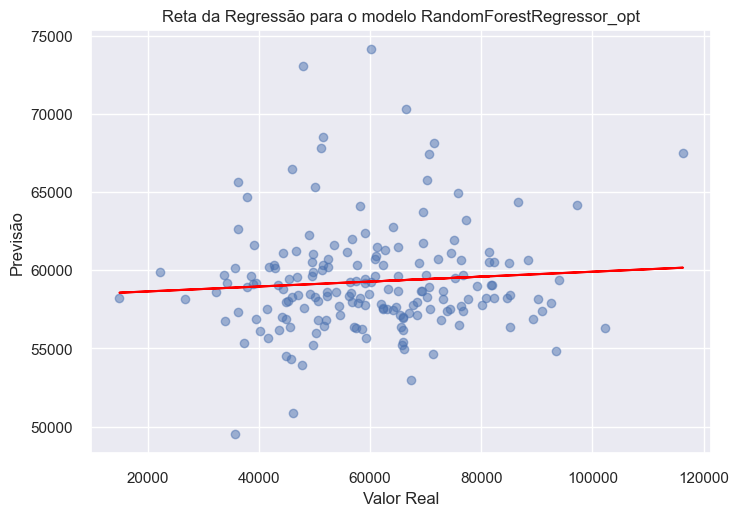

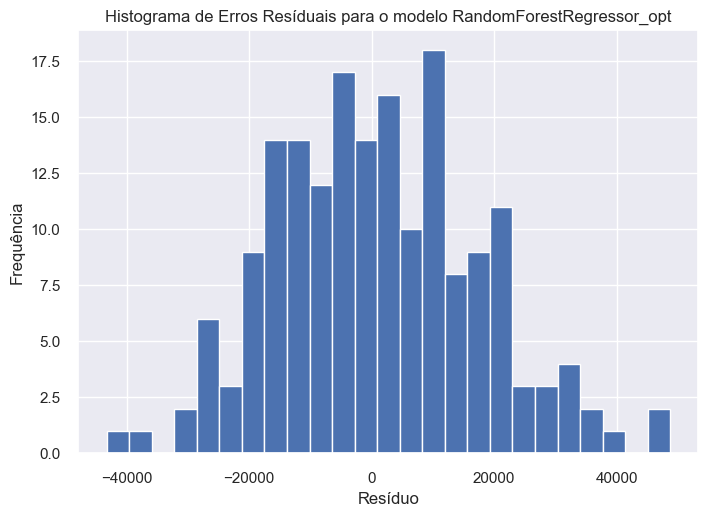

2023-04-19 10:06:37,313 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: RandomForestRegressor_opt
R2:     -0.01
RMSE:   16605.36
MAPE:   25.45%


2023-04-19 10:06:41,030 - Ciclo de vida do modelo rastreado com sucesso!


In [55]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'RandomForestRegressor_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=rfr_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### XGBOOST Otimizado

2023-04-19 10:06:41,044 - Prevendo conjunto de teste com modelo treinado
2023-04-19 10:06:41,048 - Avaliando resultados nos dados de teste


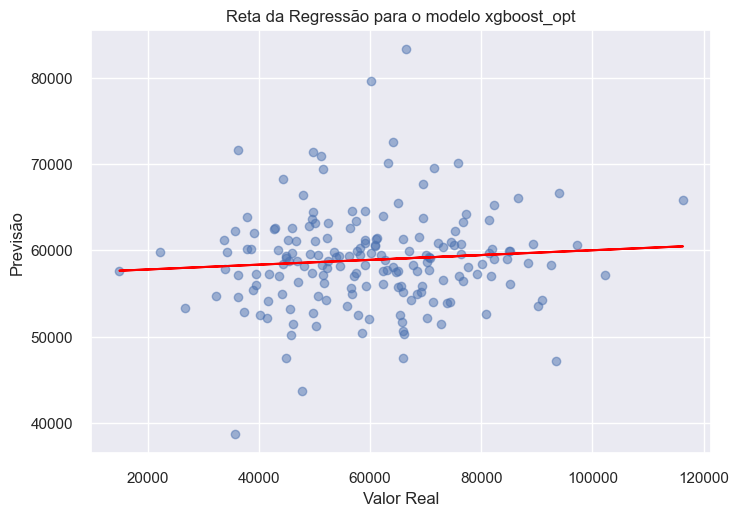

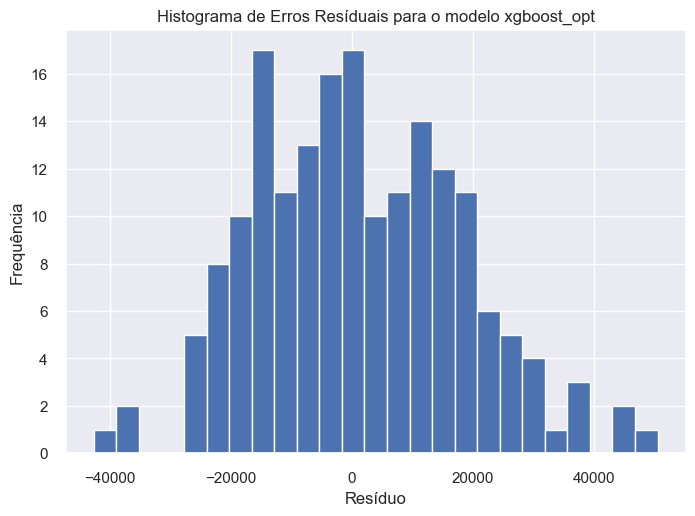

2023-04-19 10:06:41,983 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: xgboost_opt
R2:     -0.06
RMSE:   17018.87
MAPE:   25.75%


2023-04-19 10:06:45,661 - Ciclo de vida do modelo rastreado com sucesso!


In [56]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'xgboost_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=xgboost_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### LIGHTGBM Otimizado

2023-04-19 10:06:45,679 - Prevendo conjunto de teste com modelo treinado
2023-04-19 10:06:45,682 - Avaliando resultados nos dados de teste


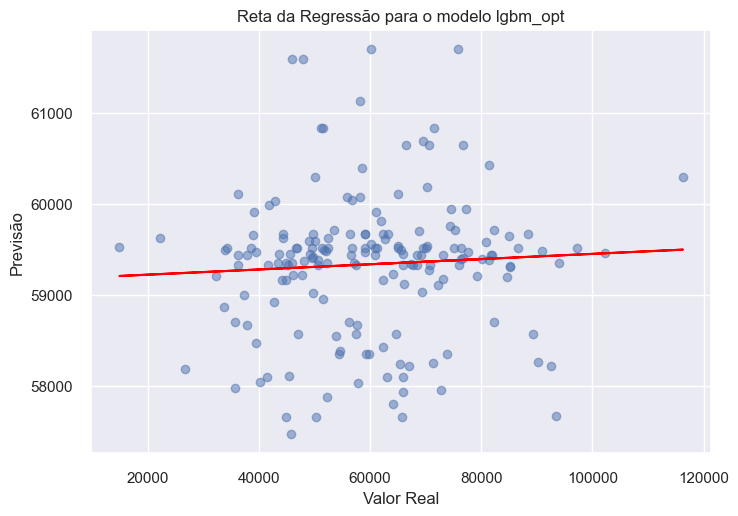

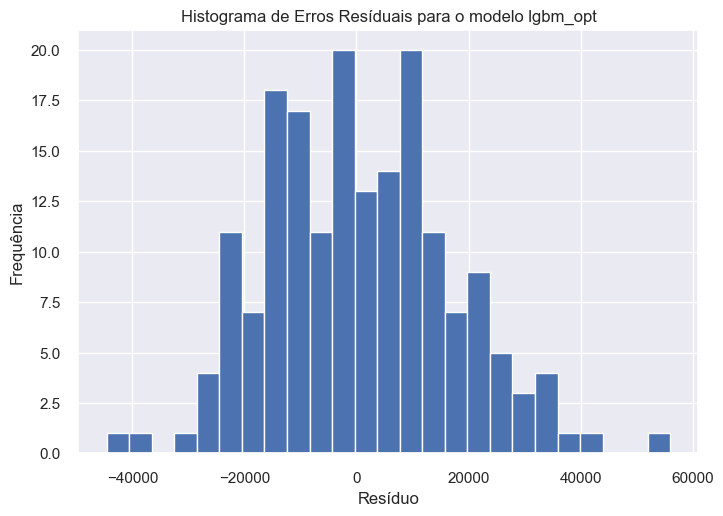

2023-04-19 10:06:46,516 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: lgbm_opt
R2:     0.00
RMSE:   16481.03
MAPE:   25.37%


2023-04-19 10:06:50,444 - Ciclo de vida do modelo rastreado com sucesso!


In [57]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'lgbm_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=lgbm_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### CATBOOST Otimizado

2023-04-19 10:06:50,458 - Prevendo conjunto de teste com modelo treinado
2023-04-19 10:06:50,461 - Avaliando resultados nos dados de teste


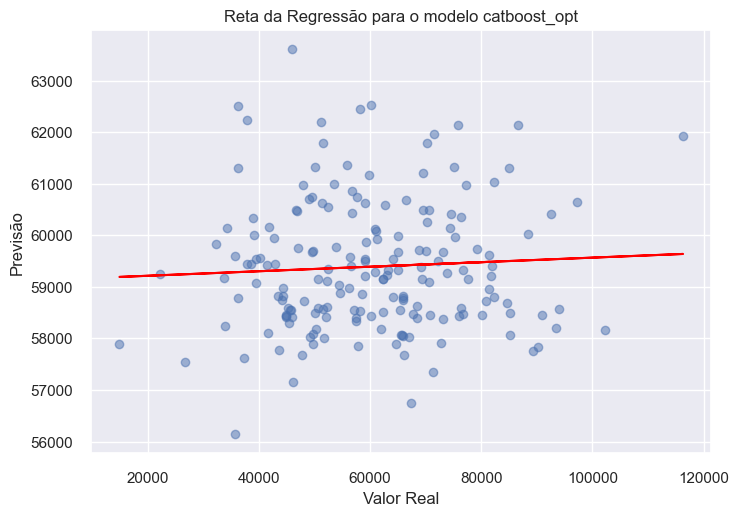

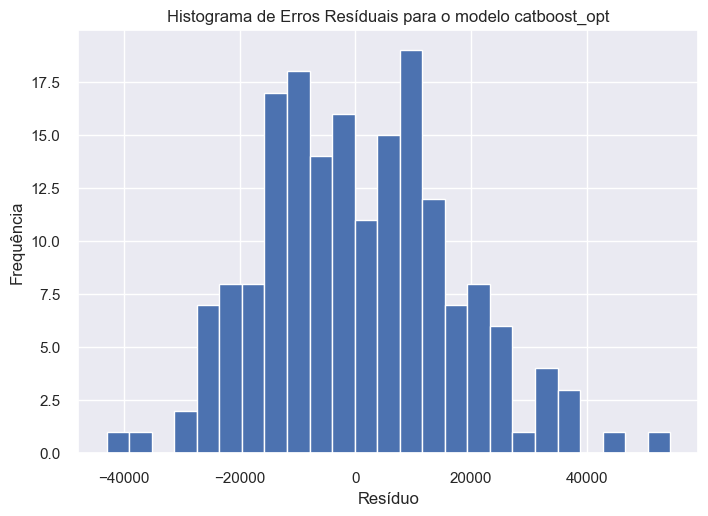

2023-04-19 10:06:51,200 - Rastreamento de resultados dos experimentos com MLFLOW iniciado


Modelo: catboost_opt
R2:     0.00
RMSE:   16483.57
MAPE:   25.42%


2023-04-19 10:06:54,822 - Ciclo de vida do modelo rastreado com sucesso!


In [58]:
experiment_name = 'Teste'

date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
model_name = 'catboost_opt'
model_name_date = model_name + ' - ' + date


test_eval(model_name=model_name, model=catboost_opt, X_test=X_test, y_test=y_test, run_name=model_name_date, experiment_name=experiment_name, path_save_fig=path_save_fig)

### Resultados no teste

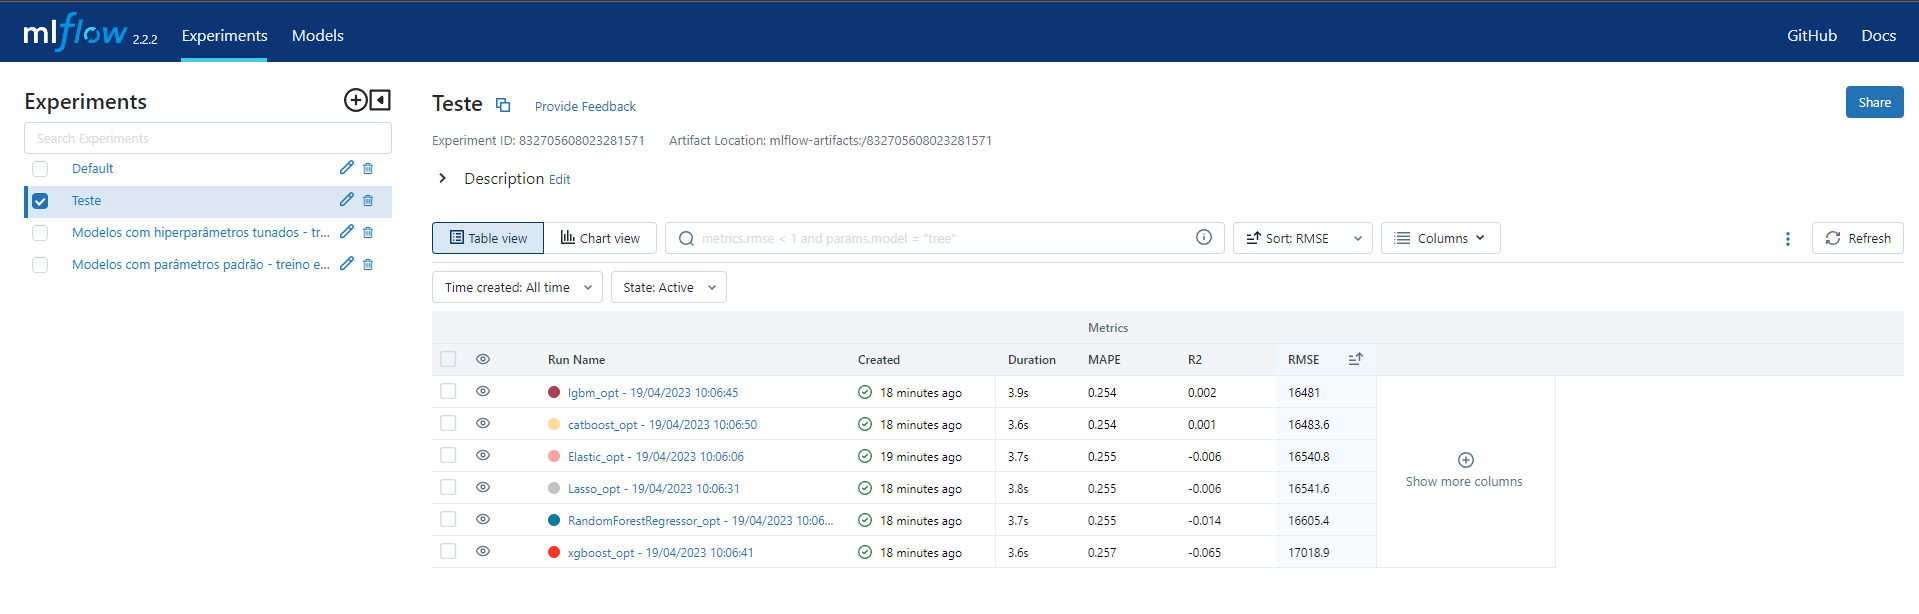

- O Lightgbm teve melhor resultado no teste

- Próximos passos :
    - Criar novas features
    - Escalonar features
    - Transformar target com escala logarítmica

# Avaliação / ROI

# Deploy